In [1]:
from google.colab import drive
drive.mount('/content/drive')
import gdown

file_id = '1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb'
url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, 'dataset.zip', quiet=False)

import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb
From (redirected): https://drive.google.com/uc?id=1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb&confirm=t&uuid=613db958-0ab4-42b1-a3b5-e6510c983901
To: /content/dataset.zip
100%|██████████| 134M/134M [00:03<00:00, 43.7MB/s]


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Define dataset paths
train_dir = 'dataset/food11/train'
val_dir = 'dataset/food11/validation'
test_dir = 'dataset/food11/test'

# Basic transform: resize and convert to tensor
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor()           # convert images to tensor format
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=basic_transform)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Check class distribution in the training set
train_labels = [label for _, label in train_dataset]
train_counter = Counter(train_labels)

print("\nTrain Dataset Class Distribution:")
for cls_idx, count in train_counter.items():
    print(f"{class_names[cls_idx]}: {count} images")

# Check class distribution in the validation set
val_labels = [label for _, label in val_dataset]
val_counter = Counter(val_labels)

print("\nValidation Dataset Class Distribution:")
for cls_idx, count in val_counter.items():
    print(f"{class_names[cls_idx]}: {count} images")

# Check class distribution in the test set
test_labels = [label for _, label in test_dataset]
test_counter = Counter(test_labels)

print("\nTest Dataset Class Distribution:")
for cls_idx, count in test_counter.items():
    print(f"{class_names[cls_idx]}: {count} images")

Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']

Train Dataset Class Distribution:
apple_pie: 200 images
cheesecake: 200 images
chicken_curry: 200 images
french_fries: 200 images
fried_rice: 200 images
hamburger: 200 images
hot_dog: 200 images
ice_cream: 200 images
omelette: 200 images
pizza: 200 images
sushi: 200 images

Validation Dataset Class Distribution:
apple_pie: 25 images
cheesecake: 25 images
chicken_curry: 25 images
french_fries: 25 images
fried_rice: 25 images
hamburger: 25 images
hot_dog: 25 images
ice_cream: 25 images
omelette: 25 images
pizza: 25 images
sushi: 25 images

Test Dataset Class Distribution:
apple_pie: 25 images
cheesecake: 25 images
chicken_curry: 25 images
french_fries: 25 images
fried_rice: 25 images
hamburger: 25 images
hot_dog: 25 images
ice_cream: 25 images
omelette: 25 images
pizza: 25 images
sushi: 25 images


In [ ]:
# 📚 DATA AUGMENTATION and DATALOADER

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                                # resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),                       # random horizontal flip
    transforms.RandomRotation(15),                                # random rotation up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                           saturation=0.2, hue=0.1),              # adjust color properties
    transforms.ToTensor(),                                        # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])                     # normalize to [-1, 1] range
])

# Define transform for validation and test data (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Load datasets with corresponding transforms
train_dataset = datasets.ImageFolder(root='dataset/food11/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='dataset/food11/validation', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='dataset/food11/test', transform=val_test_transform)

# Set batch size
batch_size = 64

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Get class names
class_names = train_dataset.classes

# Print dataset stats
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Training samples: 2200
Validation samples: 275
Test samples: 275


# **PART 1:**

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0):
        super(SimpleCNN, self).__init__()

        # Feature extractor part: 5 convolutional blocks
        self.features = nn.Sequential(
            # Conv1 block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv2 block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv3 block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv4 block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv5 block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier part: fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # dropout for regularization
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)               # pass through conv layers
        x = x.view(x.size(0), -1)          # flatten before FC layers
        x = self.classifier(x)             # pass through FC layers
        return x

In [ ]:
# ===== 1) Device =====
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ===== 2) Training & Validation Function =====
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, num_epochs + 1):
        # --- Training phase ---
        model.train()  # set model to training mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # reset gradients
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backpropagation
            optimizer.step()  # update weights

            preds = outputs.argmax(dim=1)  # get predicted class labels
            running_loss += loss.item() * inputs.size(0)  # sum loss over batch
            running_corrects += (preds == labels).sum().item()  # count correct predictions
            total_samples += inputs.size(0)

        # Calculate epoch metrics for training set
        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples

        # --- Validation phase ---
        model.eval()  # set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():  # no gradient computation in eval
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = outputs.argmax(dim=1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
                val_samples += inputs.size(0)

        # Calculate epoch metrics for validation set
        epoch_val_loss = val_loss / val_samples
        epoch_val_acc = val_corrects / val_samples

        # --- Save history and keep best model ---
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Save model weights if validation accuracy improves
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict().copy()

        # Print metrics for current epoch
        print(f'Epoch {epoch:02d}/{num_epochs:02d} » '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    # Load the best model weights after training finishes
    model.load_state_dict(best_weights)

    # --- Plot training & validation curves ---
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_acc, history

Using device: cuda


In [ ]:
def plot_overall_comparison(results_dict):
    # Plot train loss for each run
    plt.figure(figsize=(10, 5))
    for run_name, result in results_dict.items():
        history = result['history']
        epochs = range(1, len(history['train_loss']) + 1)
        label = f"{run_name} (LR={result['lr']}, BS={result['batch_size']})"  # label shows run details
        plt.plot(epochs, history['train_loss'], label=label)

    plt.title('Overall Train Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.show()

    # Plot validation loss for each run
    plt.figure(figsize=(10, 5))
    for run_name, result in results_dict.items():
        history = result['history']
        epochs = range(1, len(history['val_loss']) + 1)
        label = f"{run_name} (LR={result['lr']}, BS={result['batch_size']})"
        plt.plot(epochs, history['val_loss'], label=label)

    plt.title('Overall Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

    # Plot train accuracy for each run
    plt.figure(figsize=(10, 5))
    for run_name, result in results_dict.items():
        history = result['history']
        epochs = range(1, len(history['train_acc']) + 1)
        label = f"{run_name} (LR={result['lr']}, BS={result['batch_size']})"
        plt.plot(epochs, history['train_acc'], label=label)

    plt.title('Overall Train Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

    # Plot validation accuracy for each run
    plt.figure(figsize=(10, 5))
    for run_name, result in results_dict.items():
        history = result['history']
        epochs = range(1, len(history['val_acc']) + 1)
        label = f"{run_name} (LR={result['lr']}, BS={result['batch_size']})"
        plt.plot(epochs, history['val_acc'], label=label)

    plt.title('Overall Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()


▶️ Run 1: lr=0.0001, batch_size=64
Epoch 01/50 » Train Loss: 2.3971, Train Acc: 0.1632 | Val Loss: 2.2363, Val Acc: 0.2000
Epoch 02/50 » Train Loss: 2.1612, Train Acc: 0.2405 | Val Loss: 1.9963, Val Acc: 0.3127
Epoch 03/50 » Train Loss: 2.0412, Train Acc: 0.2945 | Val Loss: 1.9331, Val Acc: 0.3418
Epoch 04/50 » Train Loss: 1.9894, Train Acc: 0.3177 | Val Loss: 1.8607, Val Acc: 0.3782
Epoch 05/50 » Train Loss: 1.9311, Train Acc: 0.3250 | Val Loss: 1.8645, Val Acc: 0.3382
Epoch 06/50 » Train Loss: 1.8754, Train Acc: 0.3573 | Val Loss: 1.8061, Val Acc: 0.3673
Epoch 07/50 » Train Loss: 1.8167, Train Acc: 0.3759 | Val Loss: 1.7777, Val Acc: 0.4036
Epoch 08/50 » Train Loss: 1.8101, Train Acc: 0.3800 | Val Loss: 1.7869, Val Acc: 0.3927
Epoch 09/50 » Train Loss: 1.7588, Train Acc: 0.4150 | Val Loss: 1.8039, Val Acc: 0.4182
Epoch 10/50 » Train Loss: 1.7018, Train Acc: 0.4382 | Val Loss: 1.6959, Val Acc: 0.4327
Epoch 11/50 » Train Loss: 1.6134, Train Acc: 0.4773 | Val Loss: 1.6649, Val Acc: 0.4

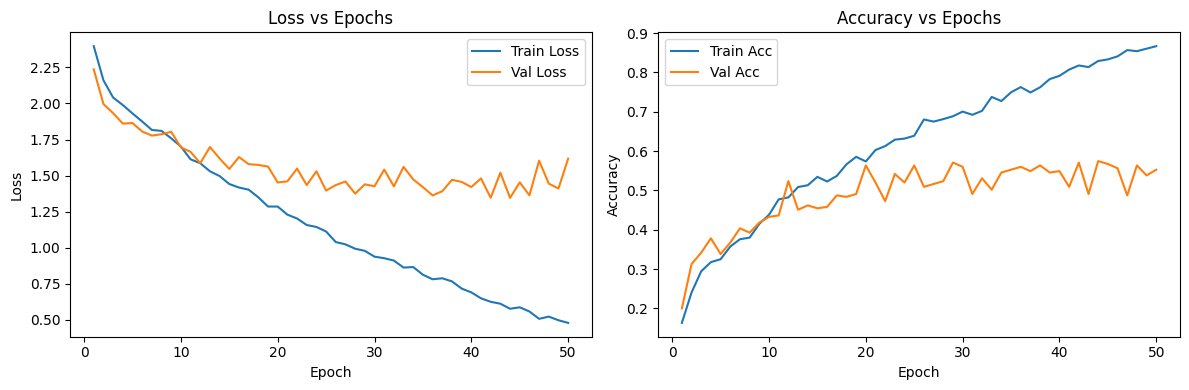

✅ Run 1 ➔ Best Val Acc: 0.5745

▶️ Run 2: lr=0.0001, batch_size=32
Epoch 01/50 » Train Loss: 2.3644, Train Acc: 0.1623 | Val Loss: 2.2331, Val Acc: 0.2109
Epoch 02/50 » Train Loss: 2.1304, Train Acc: 0.2645 | Val Loss: 2.0174, Val Acc: 0.2800
Epoch 03/50 » Train Loss: 2.0598, Train Acc: 0.2841 | Val Loss: 1.9094, Val Acc: 0.3491
Epoch 04/50 » Train Loss: 1.9547, Train Acc: 0.3236 | Val Loss: 1.8968, Val Acc: 0.3236
Epoch 05/50 » Train Loss: 1.8694, Train Acc: 0.3682 | Val Loss: 1.7670, Val Acc: 0.3709
Epoch 06/50 » Train Loss: 1.8031, Train Acc: 0.3827 | Val Loss: 1.7753, Val Acc: 0.4291
Epoch 07/50 » Train Loss: 1.7675, Train Acc: 0.4105 | Val Loss: 1.7488, Val Acc: 0.4327
Epoch 08/50 » Train Loss: 1.6876, Train Acc: 0.4318 | Val Loss: 1.6137, Val Acc: 0.4873
Epoch 09/50 » Train Loss: 1.6313, Train Acc: 0.4418 | Val Loss: 1.5452, Val Acc: 0.4982
Epoch 10/50 » Train Loss: 1.5412, Train Acc: 0.5009 | Val Loss: 1.5746, Val Acc: 0.5091
Epoch 11/50 » Train Loss: 1.5221, Train Acc: 0.5014 |

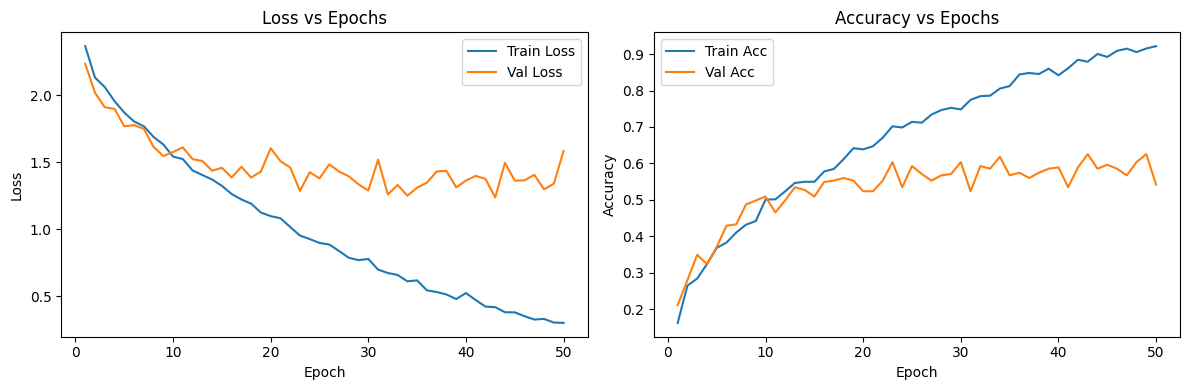

✅ Run 2 ➔ Best Val Acc: 0.6255

▶️ Run 3: lr=0.001, batch_size=64
Epoch 01/50 » Train Loss: 4.9408, Train Acc: 0.0977 | Val Loss: 2.4532, Val Acc: 0.0982
Epoch 02/50 » Train Loss: 2.4222, Train Acc: 0.1095 | Val Loss: 2.3784, Val Acc: 0.1309
Epoch 03/50 » Train Loss: 2.3574, Train Acc: 0.1368 | Val Loss: 2.3689, Val Acc: 0.1418
Epoch 04/50 » Train Loss: 2.3114, Train Acc: 0.1632 | Val Loss: 2.3025, Val Acc: 0.1236
Epoch 05/50 » Train Loss: 2.3052, Train Acc: 0.1759 | Val Loss: 2.3300, Val Acc: 0.1382
Epoch 06/50 » Train Loss: 2.2694, Train Acc: 0.1809 | Val Loss: 2.2659, Val Acc: 0.1855
Epoch 07/50 » Train Loss: 2.2250, Train Acc: 0.2095 | Val Loss: 2.2957, Val Acc: 0.1855
Epoch 08/50 » Train Loss: 2.2301, Train Acc: 0.2218 | Val Loss: 2.2280, Val Acc: 0.2400
Epoch 09/50 » Train Loss: 2.1979, Train Acc: 0.2186 | Val Loss: 2.1542, Val Acc: 0.2364
Epoch 10/50 » Train Loss: 2.1985, Train Acc: 0.2177 | Val Loss: 2.1498, Val Acc: 0.2618
Epoch 11/50 » Train Loss: 2.1581, Train Acc: 0.2368 | 

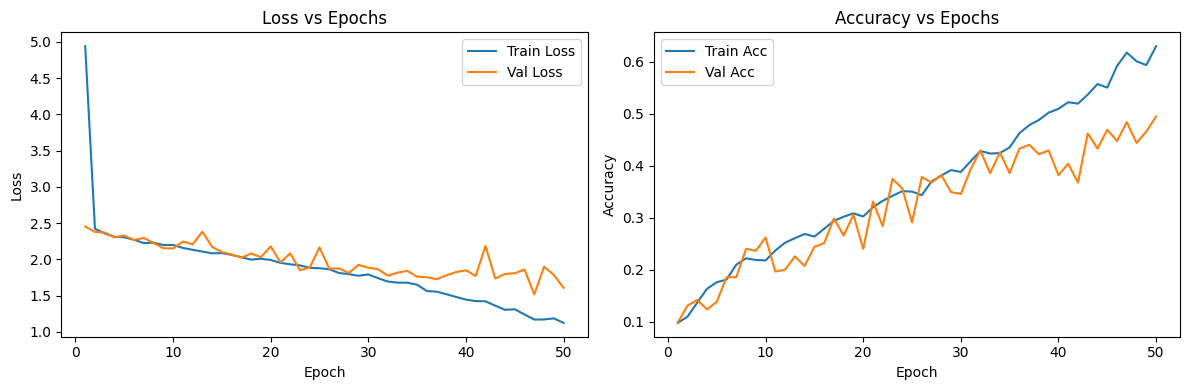

✅ Run 3 ➔ Best Val Acc: 0.4945

▶️ Run 4: lr=0.001, batch_size=32
Epoch 01/50 » Train Loss: 4.5280, Train Acc: 0.1014 | Val Loss: 2.4425, Val Acc: 0.1164
Epoch 02/50 » Train Loss: 2.4222, Train Acc: 0.1368 | Val Loss: 2.3564, Val Acc: 0.1491
Epoch 03/50 » Train Loss: 2.3286, Train Acc: 0.1668 | Val Loss: 2.3024, Val Acc: 0.1491
Epoch 04/50 » Train Loss: 2.2940, Train Acc: 0.1832 | Val Loss: 2.2389, Val Acc: 0.2109
Epoch 05/50 » Train Loss: 2.2709, Train Acc: 0.1923 | Val Loss: 2.2535, Val Acc: 0.1855
Epoch 06/50 » Train Loss: 2.2459, Train Acc: 0.2050 | Val Loss: 2.2106, Val Acc: 0.2036
Epoch 07/50 » Train Loss: 2.2251, Train Acc: 0.2141 | Val Loss: 2.2069, Val Acc: 0.2000
Epoch 08/50 » Train Loss: 2.2083, Train Acc: 0.2068 | Val Loss: 2.1701, Val Acc: 0.2545
Epoch 09/50 » Train Loss: 2.1767, Train Acc: 0.2141 | Val Loss: 2.1240, Val Acc: 0.2436
Epoch 10/50 » Train Loss: 2.1294, Train Acc: 0.2523 | Val Loss: 2.0366, Val Acc: 0.2945
Epoch 11/50 » Train Loss: 2.0942, Train Acc: 0.2605 | 

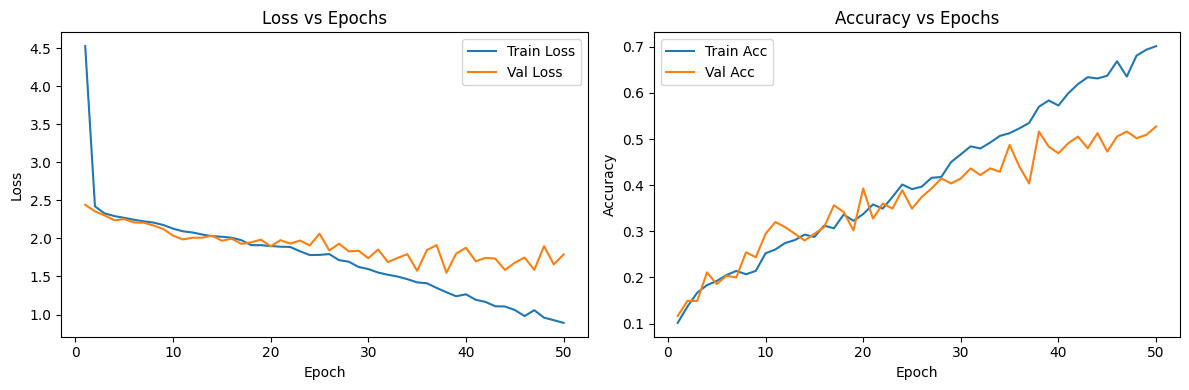

✅ Run 4 ➔ Best Val Acc: 0.5273

▶️ Run 5: lr=0.005, batch_size=64
Epoch 01/50 » Train Loss: 17.8177, Train Acc: 0.0868 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 02/50 » Train Loss: 2.3982, Train Acc: 0.0914 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 03/50 » Train Loss: 2.3983, Train Acc: 0.0905 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 04/50 » Train Loss: 2.3983, Train Acc: 0.0832 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 05/50 » Train Loss: 2.4003, Train Acc: 0.0795 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 06/50 » Train Loss: 2.3983, Train Acc: 0.0900 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 07/50 » Train Loss: 2.3983, Train Acc: 0.0791 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 08/50 » Train Loss: 2.3986, Train Acc: 0.0686 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 09/50 » Train Loss: 2.3973, Train Acc: 0.0841 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 10/50 » Train Loss: 2.4000, Train Acc: 0.0786 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 11/50 » Train Loss: 2.3976, Train Acc: 0.0914 |

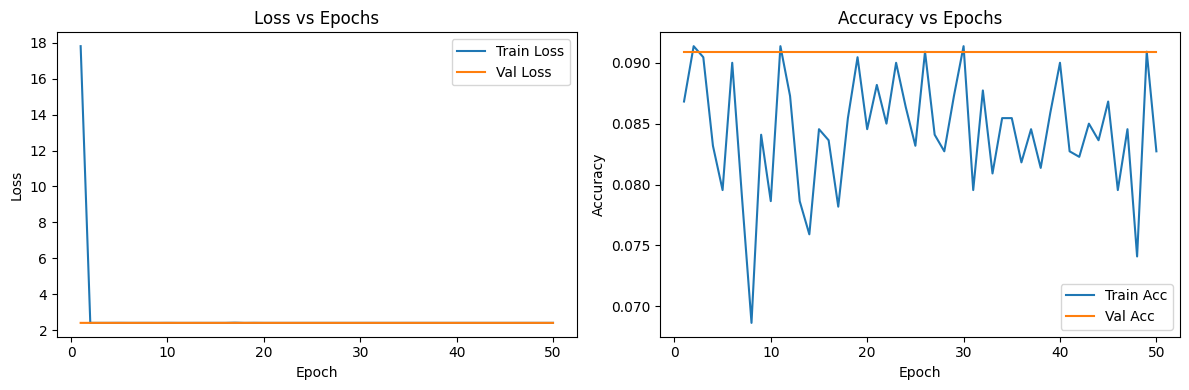

✅ Run 5 ➔ Best Val Acc: 0.0909

▶️ Run 6: lr=0.005, batch_size=32
Epoch 01/50 » Train Loss: 11.1265, Train Acc: 0.0959 | Val Loss: 2.3986, Val Acc: 0.0909
Epoch 02/50 » Train Loss: 2.4002, Train Acc: 0.0909 | Val Loss: 2.3983, Val Acc: 0.0909
Epoch 03/50 » Train Loss: 2.3988, Train Acc: 0.0823 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 04/50 » Train Loss: 2.3981, Train Acc: 0.0914 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 05/50 » Train Loss: 2.3988, Train Acc: 0.0900 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 06/50 » Train Loss: 2.3986, Train Acc: 0.0868 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 07/50 » Train Loss: 2.3987, Train Acc: 0.0859 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 08/50 » Train Loss: 2.3991, Train Acc: 0.0768 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 09/50 » Train Loss: 2.3989, Train Acc: 0.0755 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 10/50 » Train Loss: 2.3988, Train Acc: 0.0845 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 11/50 » Train Loss: 2.3987, Train Acc: 0.0836 |

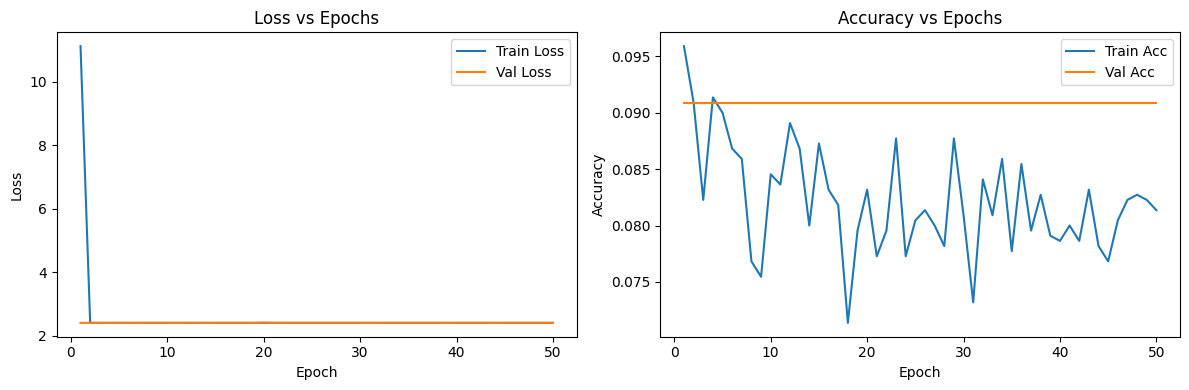

✅ Run 6 ➔ Best Val Acc: 0.0909


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# List of hyperparameter combinations to test
configs = [
    {"lr": 0.0001, "batch_size": 64},
    {"lr": 0.0001, "batch_size": 32},
    {"lr": 0.001,  "batch_size": 64},
    {"lr": 0.001,  "batch_size": 32},
    {"lr": 0.005,  "batch_size": 64},
    {"lr": 0.005,  "batch_size": 32},
]

# Dictionary to store results for each run
results_without_residual = {}

for idx, config in enumerate(configs, 1):
    print(f"\n▶️ Run {idx}: lr={config['lr']}, batch_size={config['batch_size']}")

    # Initialize model for each run
    model = SimpleCNN(num_classes=11).to(device)

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    # DataLoaders: batch_size changes in each run
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Train the model (this will also plot training curves)
    best_val_acc, history = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs=50
    )

    print(f"✅ Run {idx} ➔ Best Val Acc: {best_val_acc:.4f}")

    # Save results for later comparison
    results_without_residual[f"Run_{idx}"] = {
        "lr": config['lr'],
        "batch_size": config['batch_size'],
        "best_val_acc": best_val_acc,
        "history": history
    }


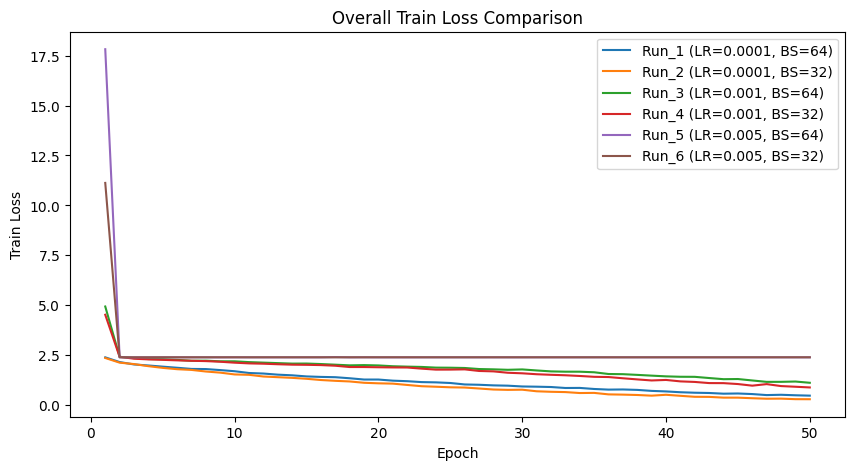

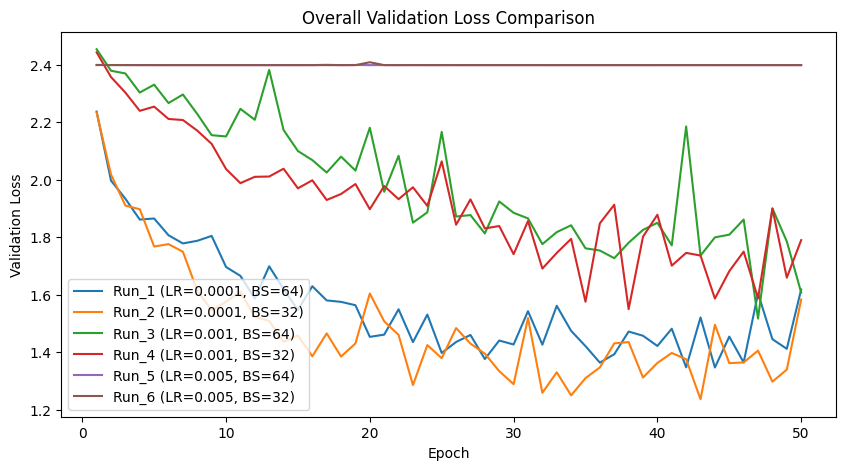

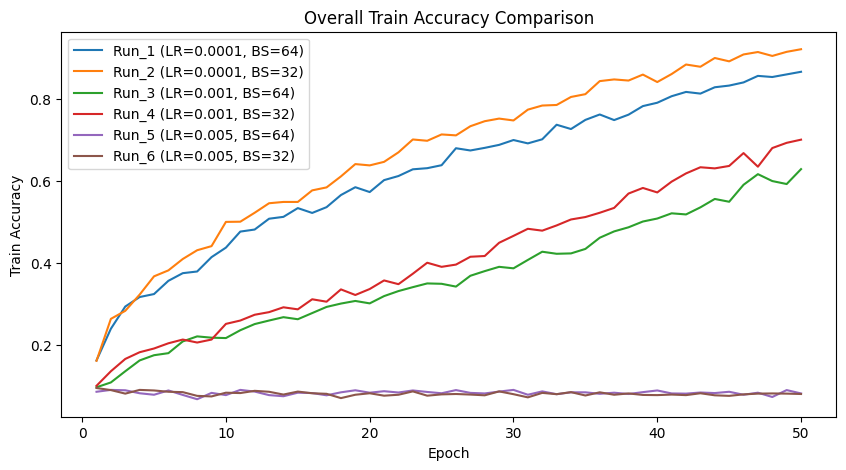

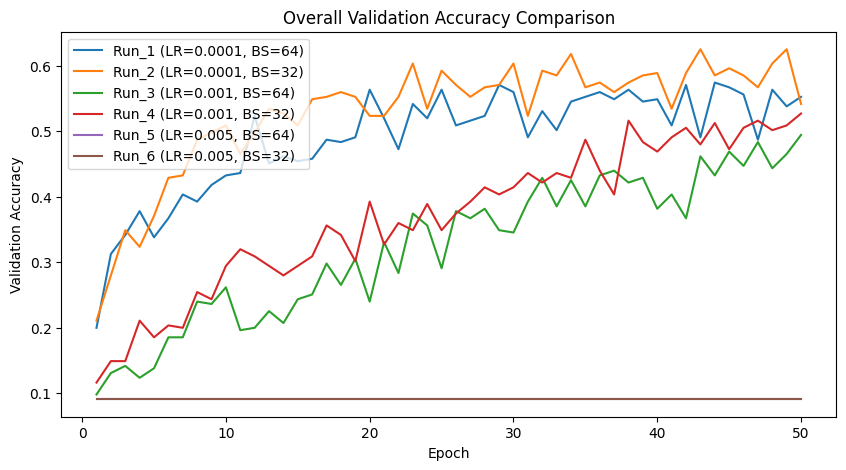

In [ ]:
plot_overall_comparison(results_without_residual)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        # First convolutional layer:
        # Keeps the same number of channels and preserves spatial size (padding=1)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)  # Normalize output for stability
        self.relu = nn.ReLU()  # Non-linear activation

        # Second convolutional layer:
        # Again keeps channels and spatial size unchanged
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x  # Save the input to add it back later (skip connection)

        # Pass through first conv + BN + ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Pass through second conv + BN
        out = self.conv2(out)
        out = self.bn2(out)

        # Add the original input (residual connection)
        out += residual

        # Apply ReLU after addition
        out = self.relu(out)

        return out


In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0):
        super(ResidualCNN, self).__init__()

        self.features = nn.Sequential(
            # Conv1 block: basic conv + BN + ReLU + pooling
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # input channels: 3 (RGB), output: 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by factor of 2

            # Conv2 block: increase channels to 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Residual block (64 channels)
            # Helps learn better features without increasing depth too much
            ResidualBlock(64),

            # Conv3 block: increase channels to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv4 block: increase channels to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Residual block (256 channels)
            # Improves gradient flow and feature reuse
            ResidualBlock(256),

            # Conv5 block: final conv layer with 512 channels
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),  # fully connected layer
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),   # dropout to prevent overfitting
            nn.Linear(256, num_classes)   # final output layer (num_classes)
        )

    def forward(self, x):
        x = self.features(x)                 # pass input through feature extractor
        x = x.view(x.size(0), -1)            # flatten before FC layers
        x = self.classifier(x)               # pass through classifier
        return x


▶️ Run 1: lr=0.0001, batch_size=64
Epoch 01/50 » Train Loss: 2.4330, Train Acc: 0.1405 | Val Loss: 2.3660, Val Acc: 0.1491
Epoch 02/50 » Train Loss: 2.1597, Train Acc: 0.2314 | Val Loss: 2.0857, Val Acc: 0.2800
Epoch 03/50 » Train Loss: 2.0649, Train Acc: 0.2745 | Val Loss: 2.0268, Val Acc: 0.2836
Epoch 04/50 » Train Loss: 2.0050, Train Acc: 0.3141 | Val Loss: 1.9384, Val Acc: 0.3309
Epoch 05/50 » Train Loss: 1.9431, Train Acc: 0.3300 | Val Loss: 1.8646, Val Acc: 0.3709
Epoch 06/50 » Train Loss: 1.8741, Train Acc: 0.3632 | Val Loss: 1.8944, Val Acc: 0.3382
Epoch 07/50 » Train Loss: 1.8220, Train Acc: 0.3882 | Val Loss: 1.7907, Val Acc: 0.4145
Epoch 08/50 » Train Loss: 1.7411, Train Acc: 0.4145 | Val Loss: 1.8406, Val Acc: 0.4000
Epoch 09/50 » Train Loss: 1.6793, Train Acc: 0.4473 | Val Loss: 1.7082, Val Acc: 0.4400
Epoch 10/50 » Train Loss: 1.6256, Train Acc: 0.4577 | Val Loss: 1.8010, Val Acc: 0.4182
Epoch 11/50 » Train Loss: 1.5394, Train Acc: 0.4900 | Val Loss: 1.5902, Val Acc: 0.4

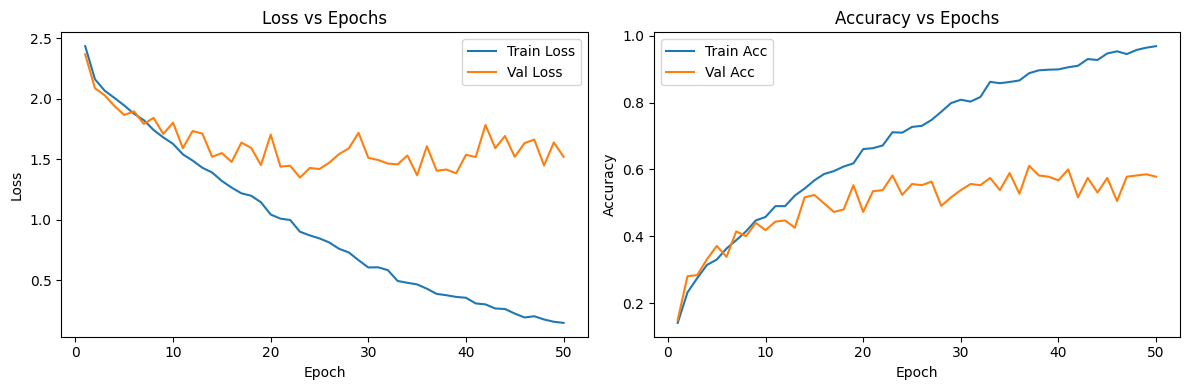

✅ Run 1 ➔ Best Val Acc: 0.6109

▶️ Run 2: lr=0.0001, batch_size=32
Epoch 01/50 » Train Loss: 2.4024, Train Acc: 0.1614 | Val Loss: 2.2279, Val Acc: 0.1855
Epoch 02/50 » Train Loss: 2.1731, Train Acc: 0.2332 | Val Loss: 2.0245, Val Acc: 0.2873
Epoch 03/50 » Train Loss: 2.0639, Train Acc: 0.2818 | Val Loss: 1.9466, Val Acc: 0.3091
Epoch 04/50 » Train Loss: 1.9905, Train Acc: 0.3159 | Val Loss: 1.9294, Val Acc: 0.3418
Epoch 05/50 » Train Loss: 1.9290, Train Acc: 0.3350 | Val Loss: 1.9349, Val Acc: 0.3164
Epoch 06/50 » Train Loss: 1.8471, Train Acc: 0.3764 | Val Loss: 1.7477, Val Acc: 0.4255
Epoch 07/50 » Train Loss: 1.7947, Train Acc: 0.3950 | Val Loss: 1.6970, Val Acc: 0.4400
Epoch 08/50 » Train Loss: 1.7602, Train Acc: 0.4000 | Val Loss: 1.7155, Val Acc: 0.4364
Epoch 09/50 » Train Loss: 1.6624, Train Acc: 0.4350 | Val Loss: 1.6758, Val Acc: 0.3855
Epoch 10/50 » Train Loss: 1.5817, Train Acc: 0.4718 | Val Loss: 1.7281, Val Acc: 0.4291
Epoch 11/50 » Train Loss: 1.5108, Train Acc: 0.4877 |

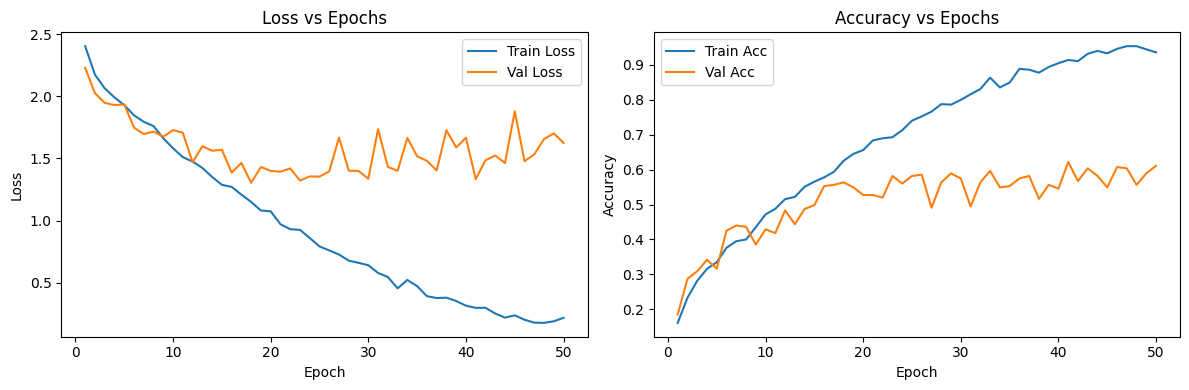

✅ Run 2 ➔ Best Val Acc: 0.6218

▶️ Run 3: lr=0.001, batch_size=64
Epoch 01/50 » Train Loss: 4.4403, Train Acc: 0.0955 | Val Loss: 2.7696, Val Acc: 0.0873
Epoch 02/50 » Train Loss: 2.5350, Train Acc: 0.1091 | Val Loss: 2.3795, Val Acc: 0.1491
Epoch 03/50 » Train Loss: 2.3598, Train Acc: 0.1386 | Val Loss: 2.2997, Val Acc: 0.1709
Epoch 04/50 » Train Loss: 2.3076, Train Acc: 0.1477 | Val Loss: 2.2552, Val Acc: 0.1418
Epoch 05/50 » Train Loss: 2.3000, Train Acc: 0.1632 | Val Loss: 2.2834, Val Acc: 0.1345
Epoch 06/50 » Train Loss: 2.2807, Train Acc: 0.1714 | Val Loss: 2.2361, Val Acc: 0.1855
Epoch 07/50 » Train Loss: 2.2736, Train Acc: 0.1700 | Val Loss: 2.2301, Val Acc: 0.1673
Epoch 08/50 » Train Loss: 2.2421, Train Acc: 0.1959 | Val Loss: 2.1817, Val Acc: 0.1964
Epoch 09/50 » Train Loss: 2.2342, Train Acc: 0.1959 | Val Loss: 2.1696, Val Acc: 0.1891
Epoch 10/50 » Train Loss: 2.2140, Train Acc: 0.2164 | Val Loss: 2.1725, Val Acc: 0.2255
Epoch 11/50 » Train Loss: 2.1631, Train Acc: 0.2345 | 

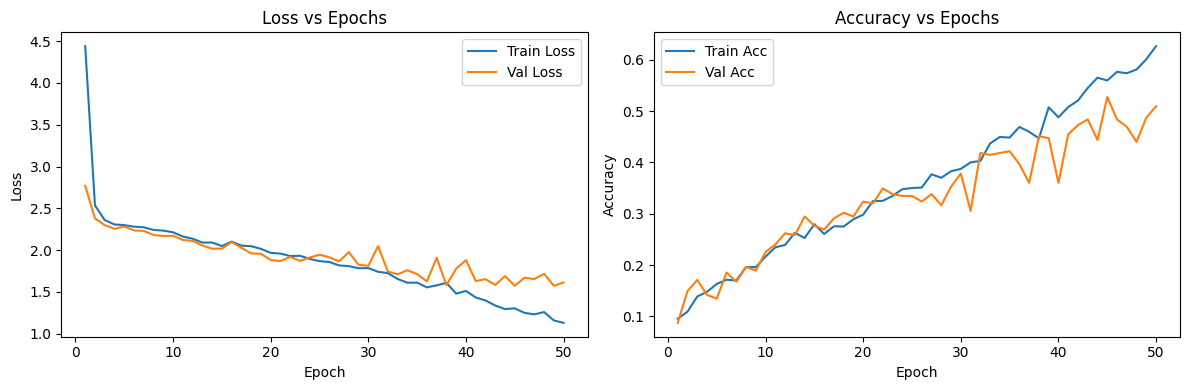

✅ Run 3 ➔ Best Val Acc: 0.5273

▶️ Run 4: lr=0.001, batch_size=32
Epoch 01/50 » Train Loss: 3.8369, Train Acc: 0.0900 | Val Loss: 2.4291, Val Acc: 0.0982
Epoch 02/50 » Train Loss: 2.3994, Train Acc: 0.1118 | Val Loss: 2.3735, Val Acc: 0.1455
Epoch 03/50 » Train Loss: 2.3549, Train Acc: 0.1350 | Val Loss: 2.2958, Val Acc: 0.1491
Epoch 04/50 » Train Loss: 2.3292, Train Acc: 0.1577 | Val Loss: 2.2741, Val Acc: 0.1709
Epoch 05/50 » Train Loss: 2.2761, Train Acc: 0.1859 | Val Loss: 2.2715, Val Acc: 0.1709
Epoch 06/50 » Train Loss: 2.2640, Train Acc: 0.1773 | Val Loss: 2.3892, Val Acc: 0.1418
Epoch 07/50 » Train Loss: 2.2263, Train Acc: 0.2082 | Val Loss: 2.2292, Val Acc: 0.2000
Epoch 08/50 » Train Loss: 2.2028, Train Acc: 0.2145 | Val Loss: 2.3230, Val Acc: 0.1964
Epoch 09/50 » Train Loss: 2.1907, Train Acc: 0.2159 | Val Loss: 2.2378, Val Acc: 0.2255
Epoch 10/50 » Train Loss: 2.1761, Train Acc: 0.2336 | Val Loss: 2.1953, Val Acc: 0.2509
Epoch 11/50 » Train Loss: 2.1615, Train Acc: 0.2395 | 

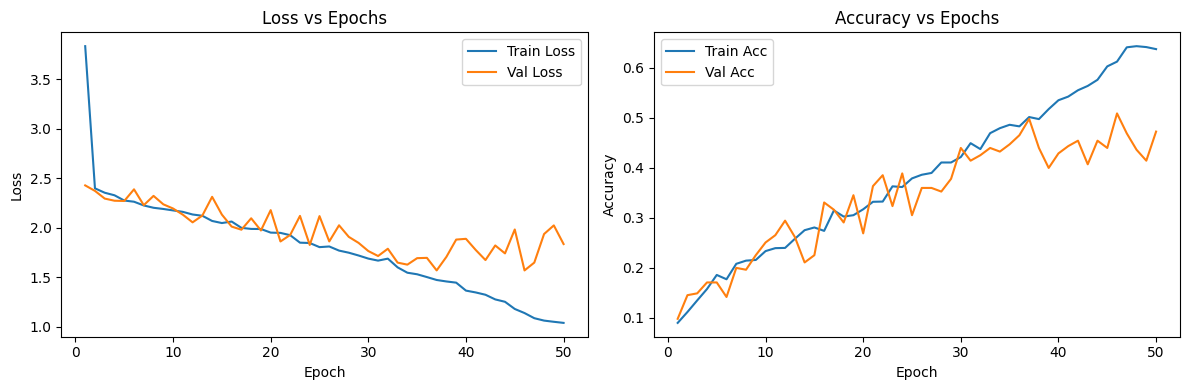

✅ Run 4 ➔ Best Val Acc: 0.5091

▶️ Run 5: lr=0.005, batch_size=64
Epoch 01/50 » Train Loss: 14.7560, Train Acc: 0.0882 | Val Loss: 2.4043, Val Acc: 0.0800
Epoch 02/50 » Train Loss: 2.4053, Train Acc: 0.0923 | Val Loss: 2.3985, Val Acc: 0.0909
Epoch 03/50 » Train Loss: 2.3999, Train Acc: 0.0800 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 04/50 » Train Loss: 2.3994, Train Acc: 0.0873 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 05/50 » Train Loss: 2.3984, Train Acc: 0.0850 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 06/50 » Train Loss: 2.3991, Train Acc: 0.0905 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 07/50 » Train Loss: 2.3983, Train Acc: 0.0814 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 08/50 » Train Loss: 2.3982, Train Acc: 0.0909 | Val Loss: 2.3981, Val Acc: 0.0909
Epoch 09/50 » Train Loss: 2.3980, Train Acc: 0.0868 | Val Loss: 2.3981, Val Acc: 0.0873
Epoch 10/50 » Train Loss: 2.3982, Train Acc: 0.0836 | Val Loss: 2.3980, Val Acc: 0.0909
Epoch 11/50 » Train Loss: 2.3982, Train Acc: 0.0805 |

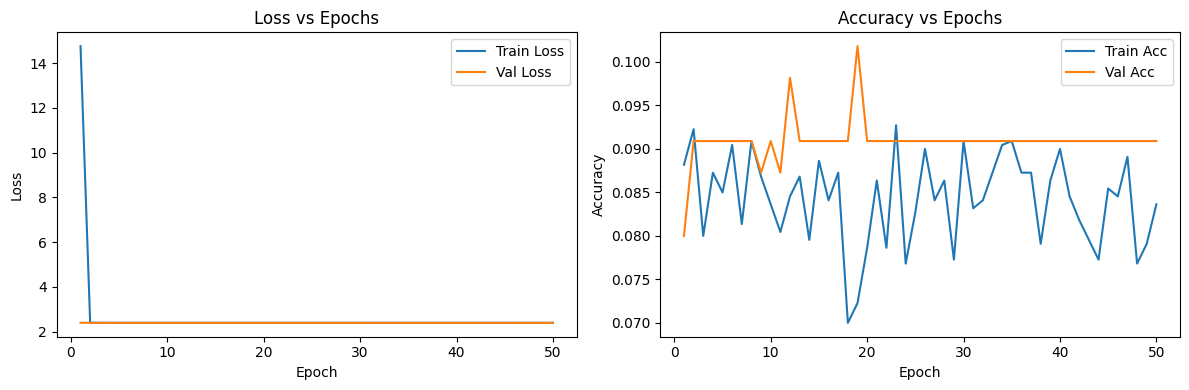

✅ Run 5 ➔ Best Val Acc: 0.1018

▶️ Run 6: lr=0.005, batch_size=32
Epoch 01/50 » Train Loss: 8.8880, Train Acc: 0.0868 | Val Loss: 2.4008, Val Acc: 0.0909
Epoch 02/50 » Train Loss: 2.4000, Train Acc: 0.0905 | Val Loss: 2.3940, Val Acc: 0.0909
Epoch 03/50 » Train Loss: 2.4018, Train Acc: 0.0855 | Val Loss: 2.3987, Val Acc: 0.0909
Epoch 04/50 » Train Loss: 2.3985, Train Acc: 0.0786 | Val Loss: 2.4063, Val Acc: 0.0909
Epoch 05/50 » Train Loss: 2.4046, Train Acc: 0.0832 | Val Loss: 2.3976, Val Acc: 0.0909
Epoch 06/50 » Train Loss: 2.3988, Train Acc: 0.0791 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 07/50 » Train Loss: 2.3987, Train Acc: 0.0823 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 08/50 » Train Loss: 2.3986, Train Acc: 0.0832 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 09/50 » Train Loss: 2.3987, Train Acc: 0.0868 | Val Loss: 2.3974, Val Acc: 0.0909
Epoch 10/50 » Train Loss: 2.4001, Train Acc: 0.0691 | Val Loss: 2.3979, Val Acc: 0.0909
Epoch 11/50 » Train Loss: 2.3989, Train Acc: 0.0755 | 

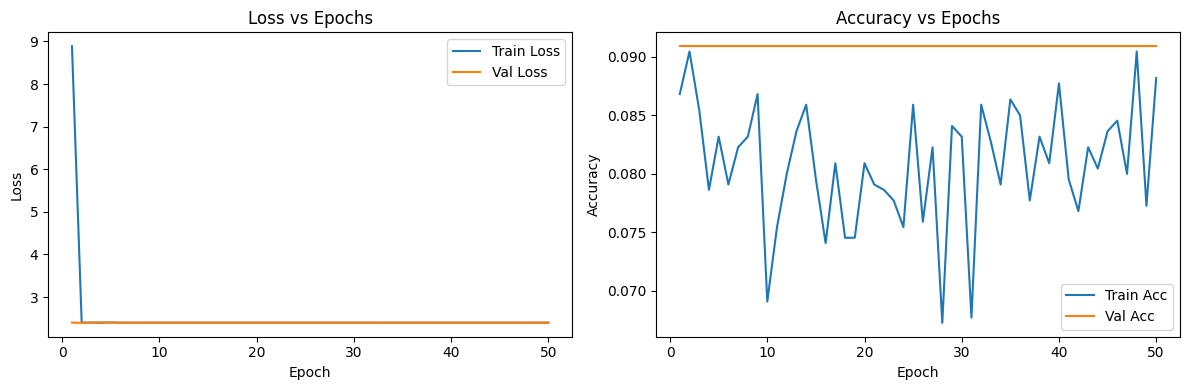

✅ Run 6 ➔ Best Val Acc: 0.0909


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Configs: list of learning rate and batch size combinations to test
configs = [
    {"lr": 0.0001, "batch_size": 64},
    {"lr": 0.0001, "batch_size": 32},
    {"lr": 0.001,  "batch_size": 64},
    {"lr": 0.001,  "batch_size": 32},
    {"lr": 0.005,  "batch_size": 64},
    {"lr": 0.005,  "batch_size": 32},
]

# Dictionary to store results for each run with ResidualCNN
results_with_residual = {}

for idx, config in enumerate(configs, 1):
    print(f"\n▶️ Run {idx}: lr={config['lr']}, batch_size={config['batch_size']}")

    # Initialize the model (ResidualCNN includes skip connections)
    model = ResidualCNN(num_classes=11).to(device)

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    # Set up DataLoaders with the current batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Train the model and collect history (plots will be shown inside train_model)
    best_val_acc, history = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs=50
    )

    print(f"✅ Run {idx} ➔ Best Val Acc: {best_val_acc:.4f}")

    # Save results for later analysis
    results_with_residual[f"Run_{idx}"] = {
        "lr": config['lr'],
        "batch_size": config['batch_size'],
        "best_val_acc": best_val_acc,
        "history": history
    }

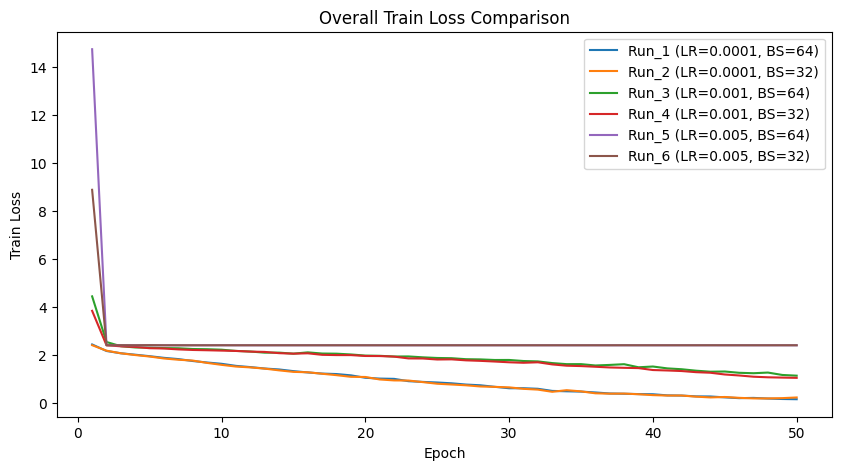

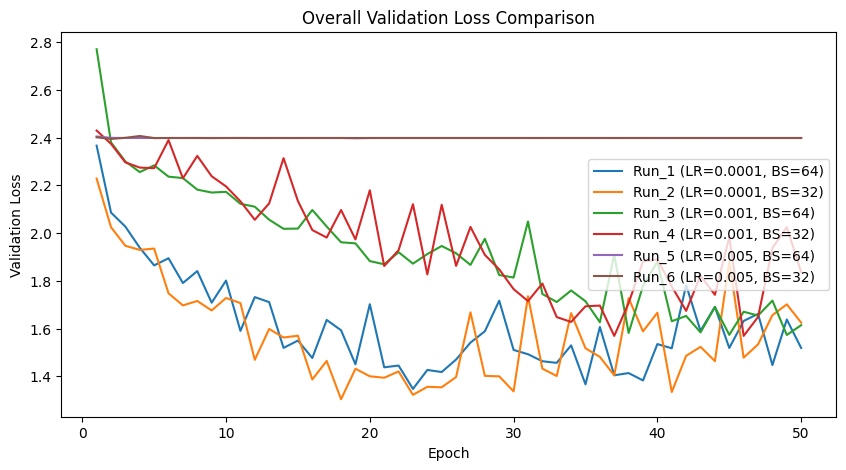

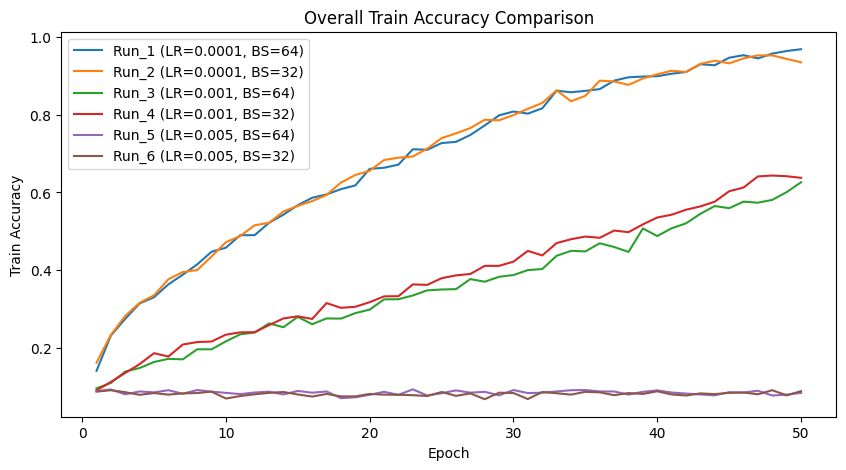

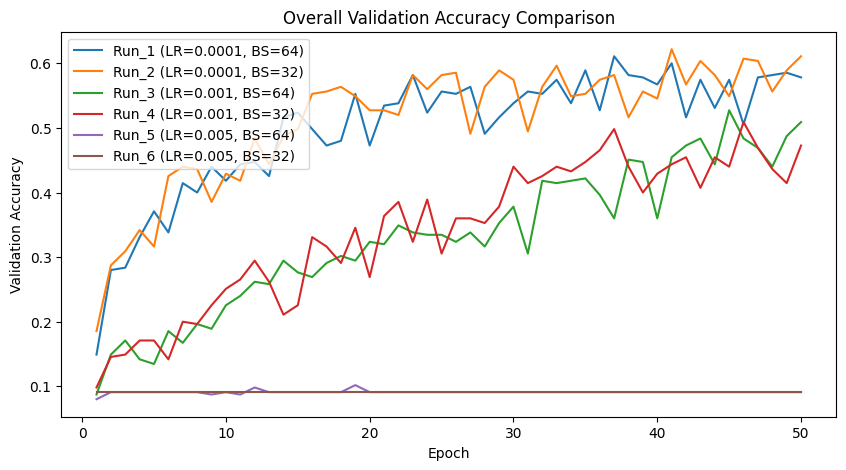

In [ ]:
plot_overall_comparison(results_with_residual)

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model_on_test(model, test_loader, class_names, model_name="Model"):
    model.eval()  # set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # disable gradient computation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass
            preds = outputs.argmax(dim=1)  # get predicted class labels
            all_preds.extend(preds.cpu().numpy())  # move to CPU & store predictions
            all_labels.extend(labels.cpu().numpy())  # store true labels

    # Calculate overall test accuracy
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy ({model_name}): {test_acc:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Print detailed classification report (precision, recall, F1-score)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("📊 Classification Report:")
    print(report)

    # Return metrics for further use
    return {
        "accuracy": test_acc,
        "confusion_matrix": cm,
        "classification_report": report
    }

**Best model for without Residual is lr=0.0001, batch_size=32
Training for calculating the test accuracy.**


▶️ Training: lr=0.0001, batch_size=32
Epoch 01/50 » Train Loss: 2.3714, Train Acc: 0.1595 | Val Loss: 2.1884, Val Acc: 0.2436
Epoch 02/50 » Train Loss: 2.1876, Train Acc: 0.2232 | Val Loss: 2.0656, Val Acc: 0.2909
Epoch 03/50 » Train Loss: 2.0966, Train Acc: 0.2618 | Val Loss: 2.0519, Val Acc: 0.2909
Epoch 04/50 » Train Loss: 2.0339, Train Acc: 0.3073 | Val Loss: 1.9921, Val Acc: 0.3091
Epoch 05/50 » Train Loss: 1.9745, Train Acc: 0.3232 | Val Loss: 1.9112, Val Acc: 0.3418
Epoch 06/50 » Train Loss: 1.9059, Train Acc: 0.3482 | Val Loss: 1.8647, Val Acc: 0.3455
Epoch 07/50 » Train Loss: 1.8457, Train Acc: 0.3864 | Val Loss: 1.8141, Val Acc: 0.4364
Epoch 08/50 » Train Loss: 1.7769, Train Acc: 0.3945 | Val Loss: 1.7338, Val Acc: 0.4145
Epoch 09/50 » Train Loss: 1.7339, Train Acc: 0.4209 | Val Loss: 1.7515, Val Acc: 0.4073
Epoch 10/50 » Train Loss: 1.6616, Train Acc: 0.4473 | Val Loss: 1.5855, Val Acc: 0.4836
Epoch 11/50 » Train Loss: 1.6157, Train Acc: 0.4677 | Val Loss: 1.6522, Val Acc: 

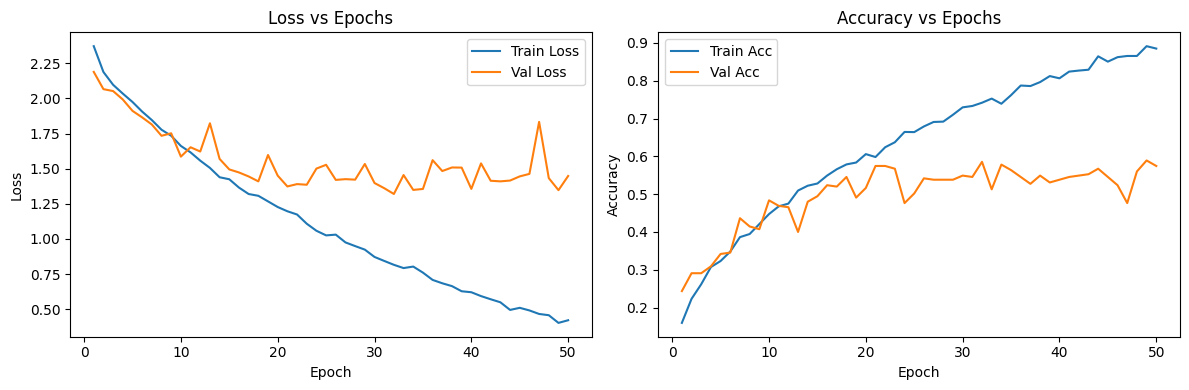

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

lr = 0.0001
batch_size = 32

print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}")

# MODEL
best_model_without_residual = SimpleCNN(num_classes=11).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(best_model_without_residual.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# DATALOADERS
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Training
best_val_acc1, history1 = train_model(
    best_model_without_residual, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

**Best model for with Residual is lr=0.0001, batch_size=32
Training for calculating the test accuracy.**


▶️ Training: lr=0.0001, batch_size=32
Epoch 01/50 » Train Loss: 2.3872, Train Acc: 0.1445 | Val Loss: 2.1818, Val Acc: 0.2291
Epoch 02/50 » Train Loss: 2.1417, Train Acc: 0.2514 | Val Loss: 1.9736, Val Acc: 0.3164
Epoch 03/50 » Train Loss: 2.0317, Train Acc: 0.2973 | Val Loss: 1.9243, Val Acc: 0.3164
Epoch 04/50 » Train Loss: 1.9553, Train Acc: 0.3227 | Val Loss: 1.8919, Val Acc: 0.3745
Epoch 05/50 » Train Loss: 1.8694, Train Acc: 0.3541 | Val Loss: 1.8852, Val Acc: 0.3491
Epoch 06/50 » Train Loss: 1.8071, Train Acc: 0.3727 | Val Loss: 1.7927, Val Acc: 0.3709
Epoch 07/50 » Train Loss: 1.7518, Train Acc: 0.4136 | Val Loss: 1.6810, Val Acc: 0.4218
Epoch 08/50 » Train Loss: 1.6347, Train Acc: 0.4441 | Val Loss: 1.6255, Val Acc: 0.4545
Epoch 09/50 » Train Loss: 1.5927, Train Acc: 0.4755 | Val Loss: 1.8287, Val Acc: 0.3927
Epoch 10/50 » Train Loss: 1.5794, Train Acc: 0.4673 | Val Loss: 1.6610, Val Acc: 0.4473
Epoch 11/50 » Train Loss: 1.4623, Train Acc: 0.5068 | Val Loss: 1.6724, Val Acc: 

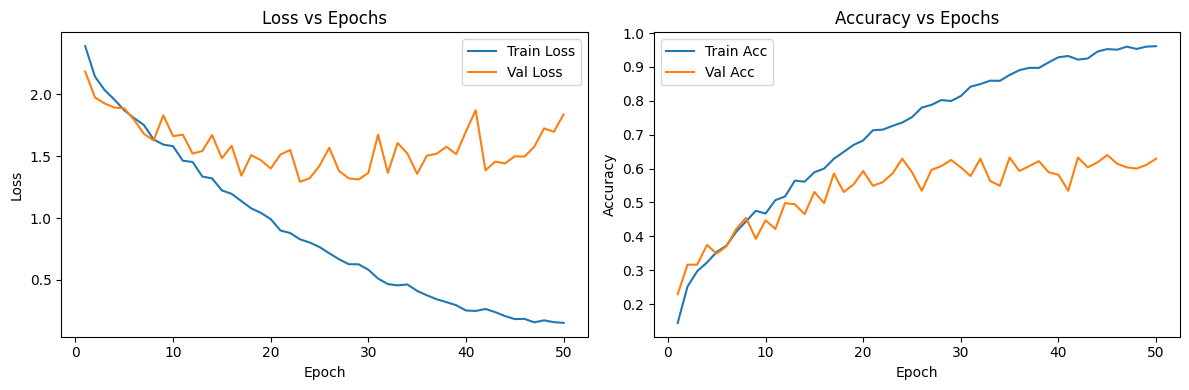

In [ ]:
print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}")

# MODEL
best_model_with_residual = ResidualCNN(num_classes=11).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(best_model_with_residual.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# DATALOADERS
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# EĞİTİM (anlık plot otomatik çizilir)
best_val_acc2, history2 = train_model(
    best_model_with_residual, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

In [ ]:
class_names = ['apple_pie','cheesecake','chicken_curry','french_fries','fried_rice','hamburger','hot_dog','ice_cream','omelette','pizza','sushi']

✅ Test Accuracy (SimpleCNN): 0.5091


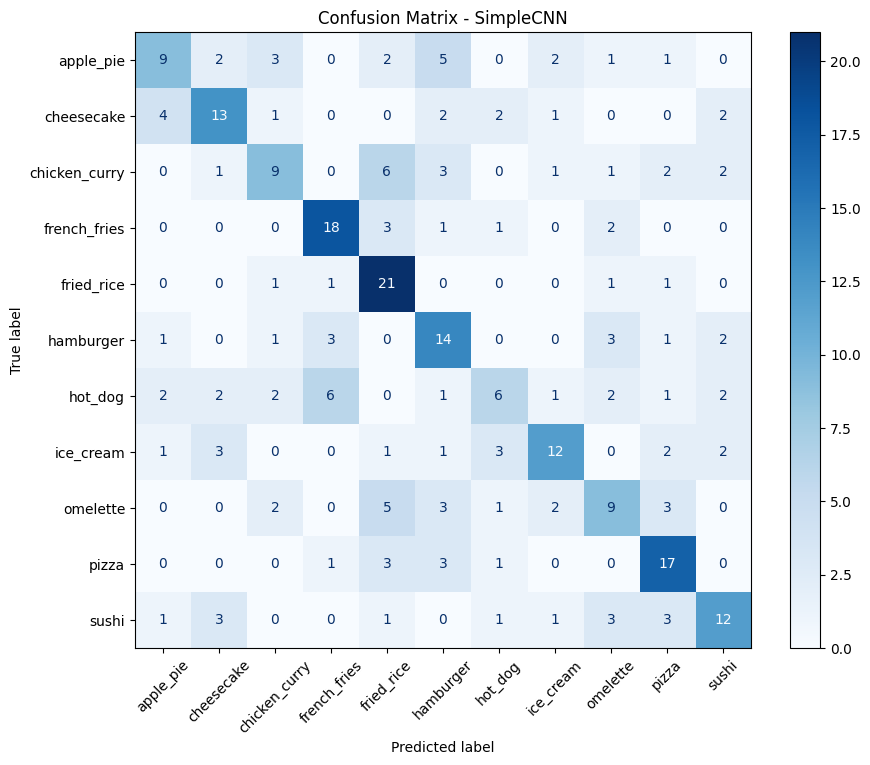

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.5000    0.3600    0.4186        25
   cheesecake     0.5417    0.5200    0.5306        25
chicken_curry     0.4737    0.3600    0.4091        25
 french_fries     0.6207    0.7200    0.6667        25
   fried_rice     0.5000    0.8400    0.6269        25
    hamburger     0.4242    0.5600    0.4828        25
      hot_dog     0.4000    0.2400    0.3000        25
    ice_cream     0.6000    0.4800    0.5333        25
     omelette     0.4091    0.3600    0.3830        25
        pizza     0.5484    0.6800    0.6071        25
        sushi     0.5455    0.4800    0.5106        25

     accuracy                         0.5091       275
    macro avg     0.5057    0.5091    0.4972       275
 weighted avg     0.5057    0.5091    0.4972       275



In [ ]:
results_without_residual = evaluate_model_on_test(
    best_model_without_residual,
    test_loader,
    class_names,
    model_name="SimpleCNN"
)

✅ Test Accuracy (ResidualCNN): 0.5018


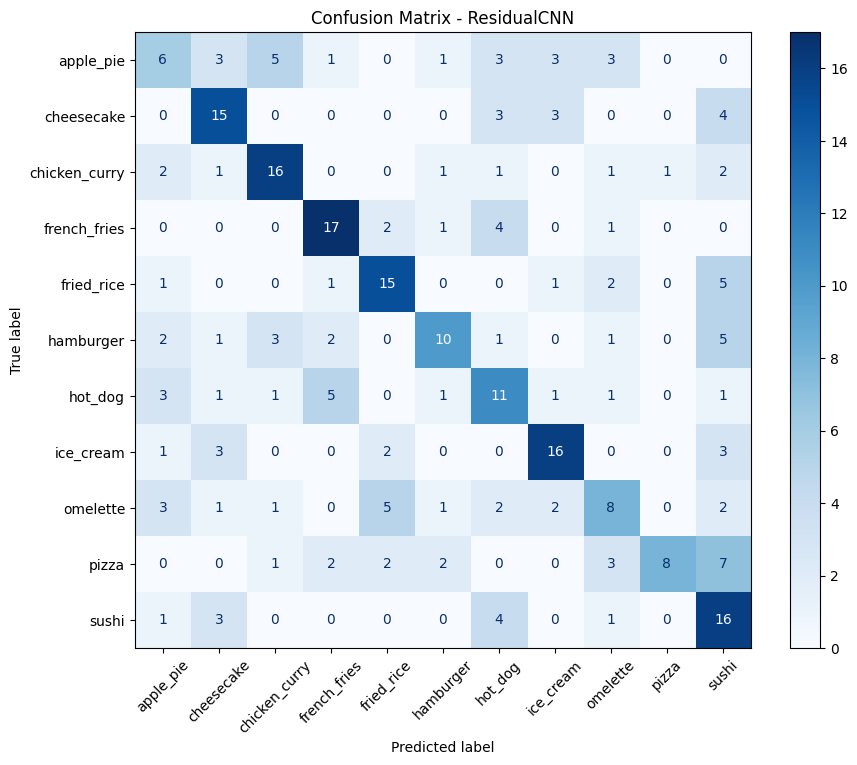

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.3158    0.2400    0.2727        25
   cheesecake     0.5357    0.6000    0.5660        25
chicken_curry     0.5926    0.6400    0.6154        25
 french_fries     0.6071    0.6800    0.6415        25
   fried_rice     0.5769    0.6000    0.5882        25
    hamburger     0.5882    0.4000    0.4762        25
      hot_dog     0.3793    0.4400    0.4074        25
    ice_cream     0.6154    0.6400    0.6275        25
     omelette     0.3810    0.3200    0.3478        25
        pizza     0.8889    0.3200    0.4706        25
        sushi     0.3556    0.6400    0.4571        25

     accuracy                         0.5018       275
    macro avg     0.5306    0.5018    0.4973       275
 weighted avg     0.5306    0.5018    0.4973       275



In [ ]:
results_with_residual = evaluate_model_on_test(
    best_model_with_residual,
    test_loader,
    class_names,
    model_name="ResidualCNN"
)

In [ ]:
# 🔧 Common parameters
batch_size = 32  # Same for both models
lr = 0.0001

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

**DROPOUT SECTION**

*Best model for without(SimpleCNN) Residual are training again for dropout values 0.3 and 0.5*


▶️ Training: lr=0.0001, batch_size=32, dropout=0.3
Epoch 01/50 » Train Loss: 2.4349, Train Acc: 0.1282 | Val Loss: 2.2829, Val Acc: 0.1564
Epoch 02/50 » Train Loss: 2.2707, Train Acc: 0.1823 | Val Loss: 2.1786, Val Acc: 0.2182
Epoch 03/50 » Train Loss: 2.2209, Train Acc: 0.2055 | Val Loss: 2.1207, Val Acc: 0.2400
Epoch 04/50 » Train Loss: 2.1711, Train Acc: 0.2400 | Val Loss: 2.0579, Val Acc: 0.2691
Epoch 05/50 » Train Loss: 2.1231, Train Acc: 0.2500 | Val Loss: 2.0968, Val Acc: 0.2509
Epoch 06/50 » Train Loss: 2.1349, Train Acc: 0.2600 | Val Loss: 1.9636, Val Acc: 0.3091
Epoch 07/50 » Train Loss: 2.0640, Train Acc: 0.2695 | Val Loss: 1.9348, Val Acc: 0.3418
Epoch 08/50 » Train Loss: 2.0343, Train Acc: 0.2914 | Val Loss: 1.9330, Val Acc: 0.3345
Epoch 09/50 » Train Loss: 2.0037, Train Acc: 0.3045 | Val Loss: 1.8763, Val Acc: 0.3382
Epoch 10/50 » Train Loss: 1.9582, Train Acc: 0.3286 | Val Loss: 1.8293, Val Acc: 0.3855
Epoch 11/50 » Train Loss: 1.9173, Train Acc: 0.3377 | Val Loss: 1.77

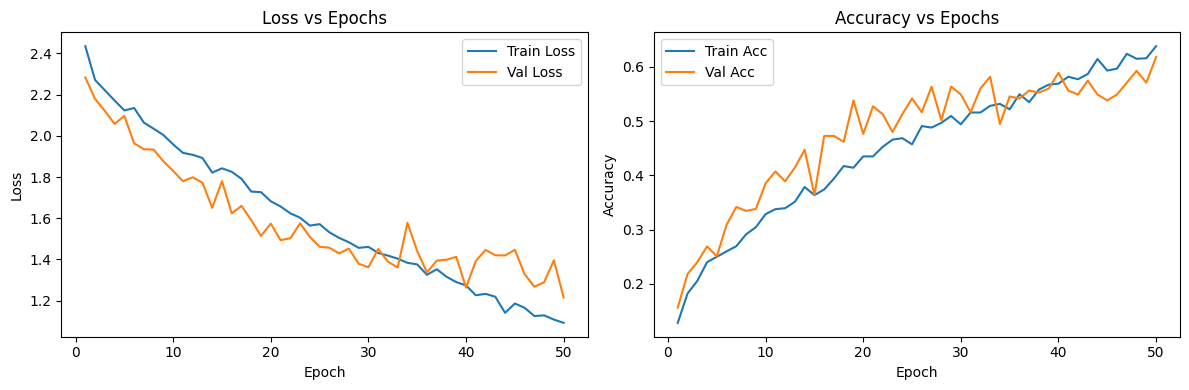

✅ Done ➔ Best Val Acc (Dropout 0.3): 0.6182


In [ ]:
dropout_value = 0.3

print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}, dropout={dropout_value}")

# MODEL
model_wR_dropout_03 = SimpleCNN(num_classes=11, dropout_rate=dropout_value).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(model_wR_dropout_03.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# TRAINING
best_val_acc_03, history_03 = train_model(
    model_wR_dropout_03, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

print(f"✅ Done ➔ Best Val Acc (Dropout {dropout_value}): {best_val_acc_03:.4f}")


▶️ Training: lr=0.0001, batch_size=32, dropout=0.5
Epoch 01/50 » Train Loss: 2.4394, Train Acc: 0.1295 | Val Loss: 2.2831, Val Acc: 0.1673
Epoch 02/50 » Train Loss: 2.3190, Train Acc: 0.1555 | Val Loss: 2.2088, Val Acc: 0.2400
Epoch 03/50 » Train Loss: 2.2809, Train Acc: 0.1686 | Val Loss: 2.1753, Val Acc: 0.2400
Epoch 04/50 » Train Loss: 2.2684, Train Acc: 0.1736 | Val Loss: 2.1777, Val Acc: 0.2436
Epoch 05/50 » Train Loss: 2.2110, Train Acc: 0.1936 | Val Loss: 2.1422, Val Acc: 0.2582
Epoch 06/50 » Train Loss: 2.2063, Train Acc: 0.2009 | Val Loss: 2.1421, Val Acc: 0.2691
Epoch 07/50 » Train Loss: 2.2092, Train Acc: 0.2123 | Val Loss: 2.1085, Val Acc: 0.2836
Epoch 08/50 » Train Loss: 2.1572, Train Acc: 0.2282 | Val Loss: 2.0663, Val Acc: 0.2982
Epoch 09/50 » Train Loss: 2.1555, Train Acc: 0.2145 | Val Loss: 2.0003, Val Acc: 0.3236
Epoch 10/50 » Train Loss: 2.1293, Train Acc: 0.2259 | Val Loss: 2.0674, Val Acc: 0.3418
Epoch 11/50 » Train Loss: 2.1451, Train Acc: 0.2300 | Val Loss: 2.06

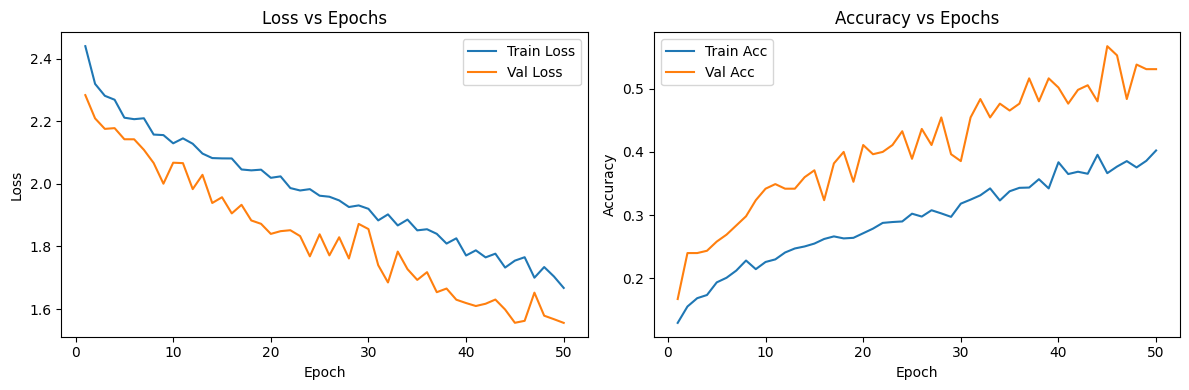

✅ Done ➔ Best Val Acc (Dropout 0.5): 0.5673


In [ ]:
dropout_value = 0.5

print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}, dropout={dropout_value}")

# MODEL
model_wR_dropout_05 = SimpleCNN(num_classes=11, dropout_rate=dropout_value).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(model_wR_dropout_05.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# TRAINING
best_val_acc_05, history_05 = train_model(
    model_wR_dropout_05, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

print(f"✅ Done ➔ Best Val Acc (Dropout {dropout_value}): {best_val_acc_05:.4f}")


✅ Test Accuracy (SimpleCNN): 0.5018


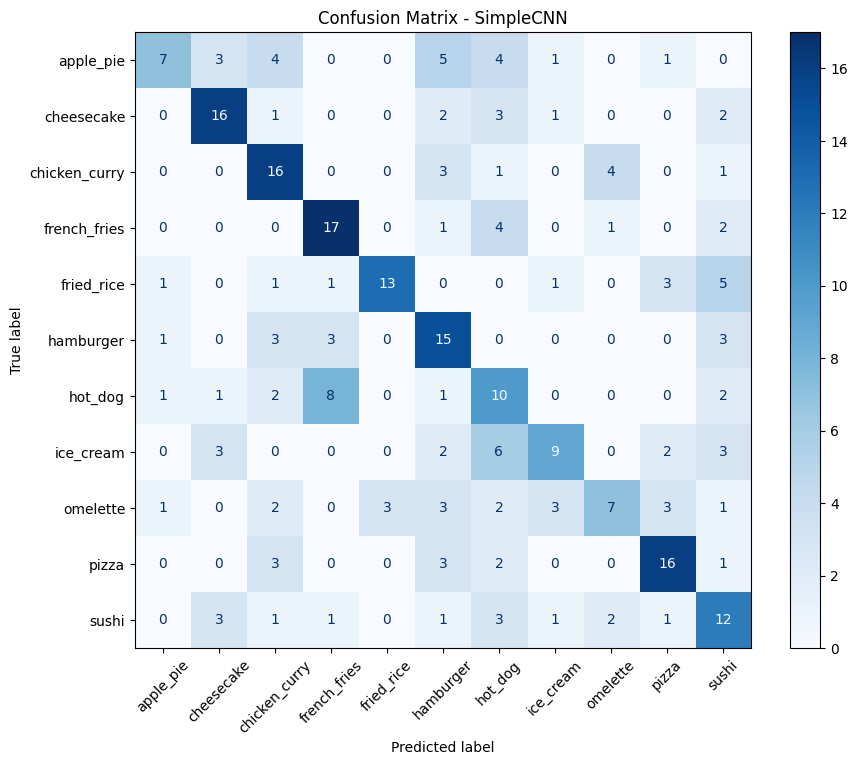

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.6364    0.2800    0.3889        25
   cheesecake     0.6154    0.6400    0.6275        25
chicken_curry     0.4848    0.6400    0.5517        25
 french_fries     0.5667    0.6800    0.6182        25
   fried_rice     0.8125    0.5200    0.6341        25
    hamburger     0.4167    0.6000    0.4918        25
      hot_dog     0.2857    0.4000    0.3333        25
    ice_cream     0.5625    0.3600    0.4390        25
     omelette     0.5000    0.2800    0.3590        25
        pizza     0.6154    0.6400    0.6275        25
        sushi     0.3750    0.4800    0.4211        25

     accuracy                         0.5018       275
    macro avg     0.5337    0.5018    0.4993       275
 weighted avg     0.5337    0.5018    0.4993       275



In [ ]:
results_without_residualD = evaluate_model_on_test(
    model_wR_dropout_03,
    test_loader,
    class_names,
    model_name="SimpleCNN"
)

✅ Test Accuracy (SimpleCNN): 0.4327


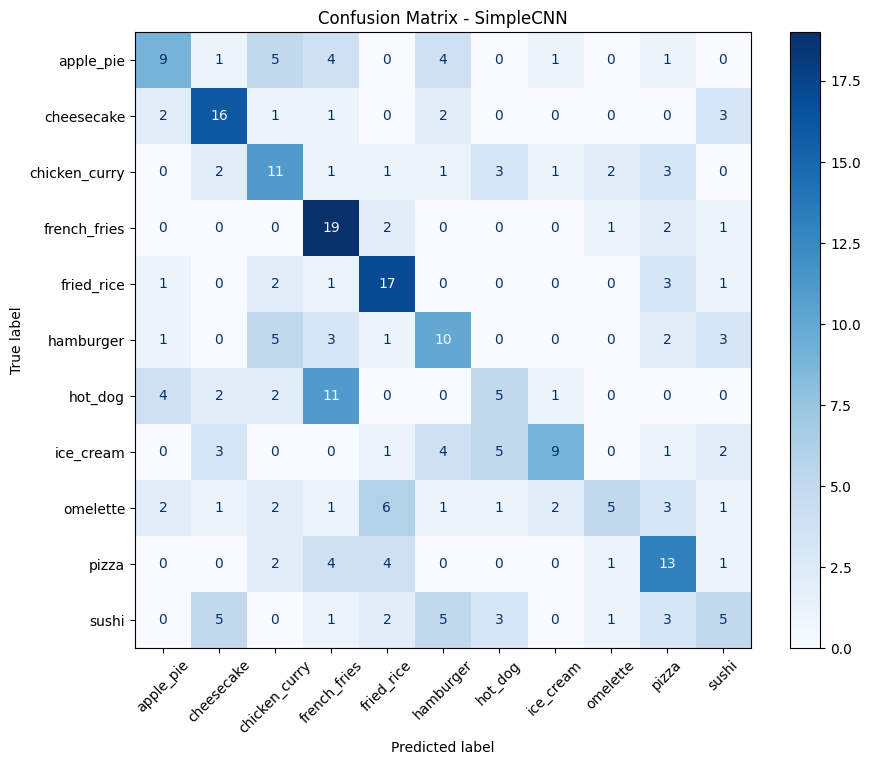

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.4737    0.3600    0.4091        25
   cheesecake     0.5333    0.6400    0.5818        25
chicken_curry     0.3667    0.4400    0.4000        25
 french_fries     0.4130    0.7600    0.5352        25
   fried_rice     0.5000    0.6800    0.5763        25
    hamburger     0.3704    0.4000    0.3846        25
      hot_dog     0.2941    0.2000    0.2381        25
    ice_cream     0.6429    0.3600    0.4615        25
     omelette     0.5000    0.2000    0.2857        25
        pizza     0.4194    0.5200    0.4643        25
        sushi     0.2941    0.2000    0.2381        25

     accuracy                         0.4327       275
    macro avg     0.4370    0.4327    0.4159       275
 weighted avg     0.4370    0.4327    0.4159       275



In [ ]:
results_without_residualD = evaluate_model_on_test(
    model_wR_dropout_05,
    test_loader,
    class_names,
    model_name="SimpleCNN"
)

*Best model for with Residual are training again for dropout values 0.3 and 0.5*


▶️ Training: lr=0.0001, batch_size=32, dropout=0.3
Epoch 01/50 » Train Loss: 2.4364, Train Acc: 0.1336 | Val Loss: 2.2679, Val Acc: 0.1818
Epoch 02/50 » Train Loss: 2.2815, Train Acc: 0.1791 | Val Loss: 2.2077, Val Acc: 0.2255
Epoch 03/50 » Train Loss: 2.2424, Train Acc: 0.2059 | Val Loss: 2.1091, Val Acc: 0.2945
Epoch 04/50 » Train Loss: 2.1796, Train Acc: 0.2259 | Val Loss: 2.0533, Val Acc: 0.2509
Epoch 05/50 » Train Loss: 2.1611, Train Acc: 0.2355 | Val Loss: 2.0480, Val Acc: 0.3127
Epoch 06/50 » Train Loss: 2.1121, Train Acc: 0.2532 | Val Loss: 2.0237, Val Acc: 0.3091
Epoch 07/50 » Train Loss: 2.0720, Train Acc: 0.2795 | Val Loss: 2.0626, Val Acc: 0.2691
Epoch 08/50 » Train Loss: 2.0362, Train Acc: 0.2873 | Val Loss: 1.9577, Val Acc: 0.3127
Epoch 09/50 » Train Loss: 2.0233, Train Acc: 0.3000 | Val Loss: 1.8569, Val Acc: 0.3673
Epoch 10/50 » Train Loss: 1.9889, Train Acc: 0.3141 | Val Loss: 1.8168, Val Acc: 0.3818
Epoch 11/50 » Train Loss: 1.9722, Train Acc: 0.3145 | Val Loss: 1.80

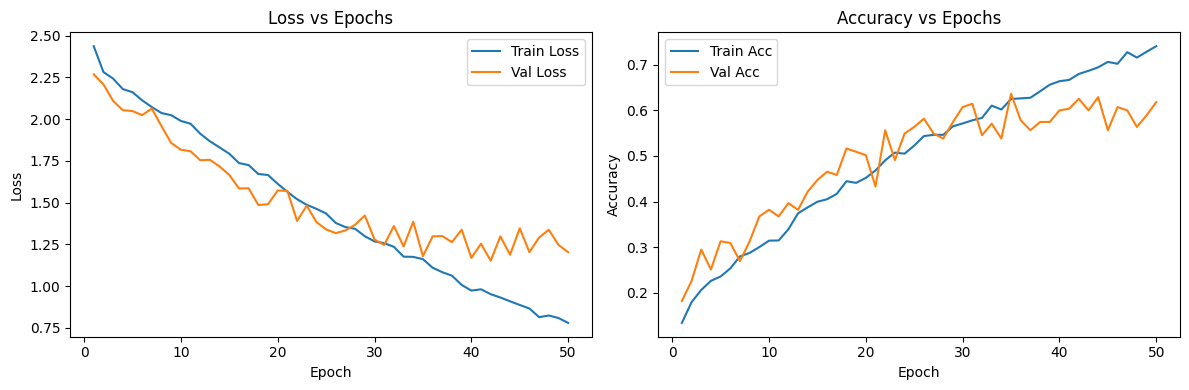

✅ Done ➔ Best Val Acc (Dropout 0.3): 0.6364


In [ ]:
dropout_value = 0.3

print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}, dropout={dropout_value}")

# MODEL
model_R_dropout_03 = ResidualCNN(num_classes=11, dropout_rate=dropout_value).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(model_R_dropout_03.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# TRAINING
best_val_acc_03, history_03 = train_model(
    model_R_dropout_03, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

print(f"✅ Done ➔ Best Val Acc (Dropout {dropout_value}): {best_val_acc_03:.4f}")


▶️ Training: lr=0.0001, batch_size=32, dropout=0.5
Epoch 01/50 » Train Loss: 2.4481, Train Acc: 0.1345 | Val Loss: 2.2279, Val Acc: 0.2727
Epoch 02/50 » Train Loss: 2.2897, Train Acc: 0.1841 | Val Loss: 2.1457, Val Acc: 0.2400
Epoch 03/50 » Train Loss: 2.2384, Train Acc: 0.1950 | Val Loss: 2.1247, Val Acc: 0.2436
Epoch 04/50 » Train Loss: 2.2270, Train Acc: 0.2041 | Val Loss: 2.1785, Val Acc: 0.2400
Epoch 05/50 » Train Loss: 2.1859, Train Acc: 0.2314 | Val Loss: 2.0580, Val Acc: 0.2836
Epoch 06/50 » Train Loss: 2.1784, Train Acc: 0.2273 | Val Loss: 1.9941, Val Acc: 0.3164
Epoch 07/50 » Train Loss: 2.1497, Train Acc: 0.2423 | Val Loss: 2.0100, Val Acc: 0.3636
Epoch 08/50 » Train Loss: 2.1214, Train Acc: 0.2591 | Val Loss: 1.9784, Val Acc: 0.3018
Epoch 09/50 » Train Loss: 2.0965, Train Acc: 0.2523 | Val Loss: 1.9432, Val Acc: 0.3600
Epoch 10/50 » Train Loss: 2.0828, Train Acc: 0.2591 | Val Loss: 1.9731, Val Acc: 0.3382
Epoch 11/50 » Train Loss: 2.0801, Train Acc: 0.2536 | Val Loss: 1.93

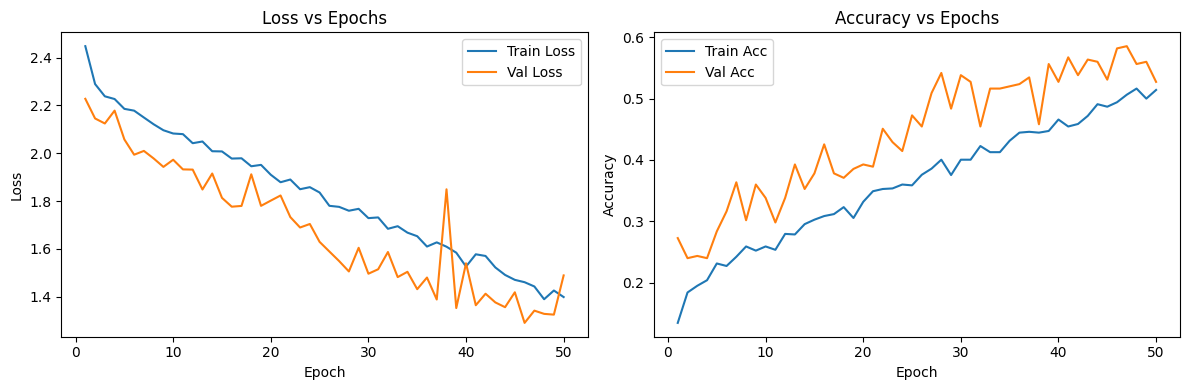

✅ Done ➔ Best Val Acc (Dropout 0.5): 0.5855


In [ ]:
dropout_value = 0.5

print(f"\n▶️ Training: lr={lr}, batch_size={batch_size}, dropout={dropout_value}")

# MODEL
model_R_dropout_05 = ResidualCNN(num_classes=11, dropout_rate=dropout_value).to(device)

# OPTIMIZER & LOSS
optimizer = optim.Adam(model_R_dropout_05.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# TRAINING
best_val_acc_05, history_05 = train_model(
    model_R_dropout_05, train_loader, val_loader, optimizer, criterion, num_epochs=50
)

print(f"✅ Done ➔ Best Val Acc (Dropout {dropout_value}): {best_val_acc_05:.4f}")


✅ Test Accuracy (ResidualCNN): 0.5200


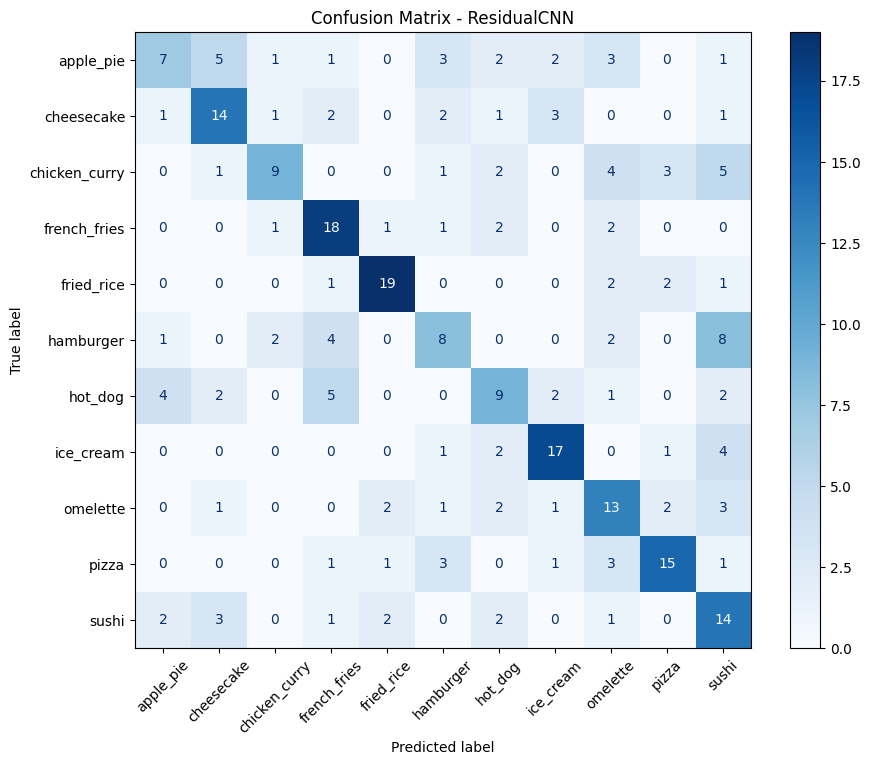

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.4667    0.2800    0.3500        25
   cheesecake     0.5385    0.5600    0.5490        25
chicken_curry     0.6429    0.3600    0.4615        25
 french_fries     0.5455    0.7200    0.6207        25
   fried_rice     0.7600    0.7600    0.7600        25
    hamburger     0.4000    0.3200    0.3556        25
      hot_dog     0.4091    0.3600    0.3830        25
    ice_cream     0.6538    0.6800    0.6667        25
     omelette     0.4194    0.5200    0.4643        25
        pizza     0.6522    0.6000    0.6250        25
        sushi     0.3500    0.5600    0.4308        25

     accuracy                         0.5200       275
    macro avg     0.5307    0.5200    0.5151       275
 weighted avg     0.5307    0.5200    0.5151       275



In [ ]:
results_with_residualD = evaluate_model_on_test(
    model_R_dropout_03,
    test_loader,
    class_names,
    model_name="ResidualCNN"
)

✅ Test Accuracy (ResidualCNN): 0.4727


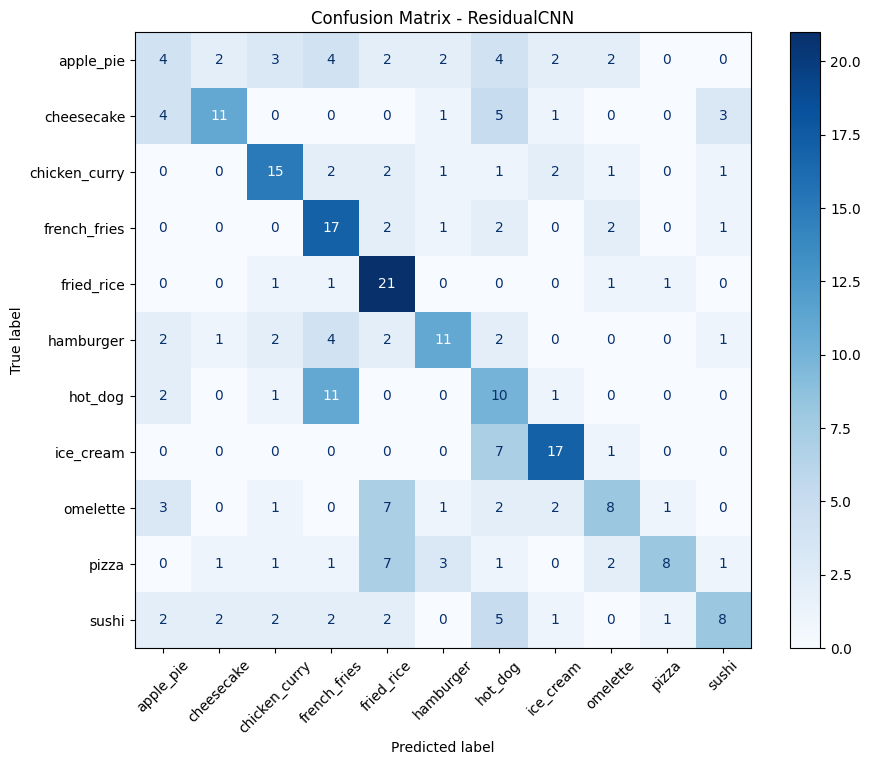

📊 Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.2353    0.1600    0.1905        25
   cheesecake     0.6471    0.4400    0.5238        25
chicken_curry     0.5769    0.6000    0.5882        25
 french_fries     0.4048    0.6800    0.5075        25
   fried_rice     0.4667    0.8400    0.6000        25
    hamburger     0.5500    0.4400    0.4889        25
      hot_dog     0.2564    0.4000    0.3125        25
    ice_cream     0.6538    0.6800    0.6667        25
     omelette     0.4706    0.3200    0.3810        25
        pizza     0.7273    0.3200    0.4444        25
        sushi     0.5333    0.3200    0.4000        25

     accuracy                         0.4727       275
    macro avg     0.5020    0.4727    0.4639       275
 weighted avg     0.5020    0.4727    0.4639       275



In [ ]:
results_with_residualD = evaluate_model_on_test(
    model_R_dropout_05,
    test_loader,
    class_names,
    model_name="ResidualCNN"
)

# **PART 2:**

In [12]:
import torchvision.models as models
import torch.nn as nn

# 1. Load pretrained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# 2. Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# 3. Replace the classifier (FC) layer with new one for 11 classes
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 11)

# 4. Ensure only the new classifier layer is trainable
for param in mobilenet_v2.classifier[1].parameters():
    param.requires_grad = True

# 5. Move model to device
mobilenet_v2 = mobilenet_v2.to(device)
print("✅ MobileNetV2 ready for fine-tuning (FC layer only)")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 214MB/s]


✅ MobileNetV2 ready for fine-tuning (FC layer only)


Epoch 01/50 » Train Loss: 1.8874, Train Acc: 0.4023 | Val Loss: 1.0837, Val Acc: 0.7673
Epoch 02/50 » Train Loss: 1.2551, Train Acc: 0.6250 | Val Loss: 0.8859, Val Acc: 0.7491
Epoch 03/50 » Train Loss: 1.1018, Train Acc: 0.6655 | Val Loss: 0.6815, Val Acc: 0.8218
Epoch 04/50 » Train Loss: 1.0109, Train Acc: 0.6914 | Val Loss: 0.6332, Val Acc: 0.8145
Epoch 05/50 » Train Loss: 0.9772, Train Acc: 0.6950 | Val Loss: 0.5537, Val Acc: 0.8473
Epoch 06/50 » Train Loss: 0.9026, Train Acc: 0.7191 | Val Loss: 0.5490, Val Acc: 0.8218
Epoch 07/50 » Train Loss: 0.8749, Train Acc: 0.7218 | Val Loss: 0.5052, Val Acc: 0.8509
Epoch 08/50 » Train Loss: 0.8731, Train Acc: 0.7123 | Val Loss: 0.4967, Val Acc: 0.8655
Epoch 09/50 » Train Loss: 0.8190, Train Acc: 0.7400 | Val Loss: 0.4964, Val Acc: 0.8582
Epoch 10/50 » Train Loss: 0.8058, Train Acc: 0.7391 | Val Loss: 0.5269, Val Acc: 0.8327
Epoch 11/50 » Train Loss: 0.8166, Train Acc: 0.7309 | Val Loss: 0.5125, Val Acc: 0.8545
Epoch 12/50 » Train Loss: 0.8222

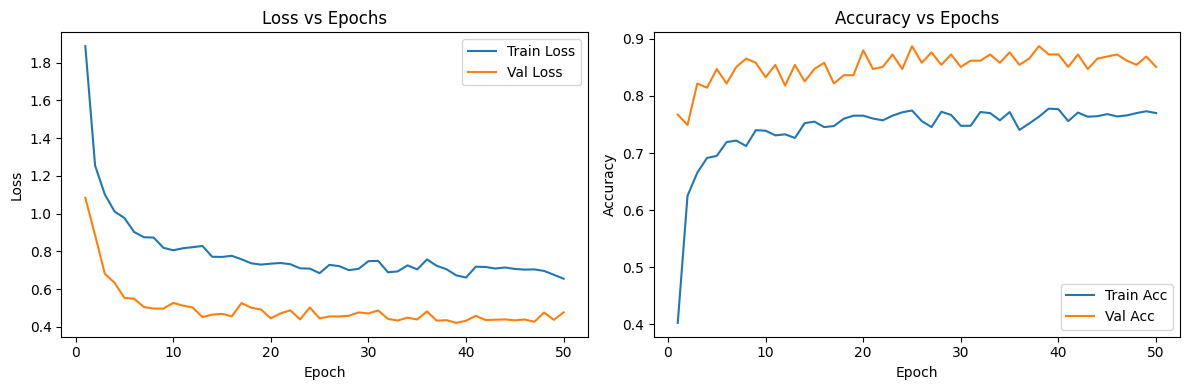

In [ ]:
import torch.optim as optim

# Set up loss function and optimizer (training only the FC layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier[1].parameters(), lr=1e-3)

# Start training using the existing train_model function (plots included)
best_val_acc = train_model(mobilenet_v2, train_loader, val_loader, optimizer, criterion, num_epochs=50)

✅ MobileNetV2 ready for fine-tuning (last 2 conv + FC)
Epoch 01/50 » Train Loss: 1.8227, Train Acc: 0.4700 | Val Loss: 0.9814, Val Acc: 0.8109
Epoch 02/50 » Train Loss: 1.1299, Train Acc: 0.6723 | Val Loss: 0.6109, Val Acc: 0.8582
Epoch 03/50 » Train Loss: 0.9160, Train Acc: 0.7250 | Val Loss: 0.4921, Val Acc: 0.8764
Epoch 04/50 » Train Loss: 0.7952, Train Acc: 0.7573 | Val Loss: 0.4392, Val Acc: 0.8800
Epoch 05/50 » Train Loss: 0.7199, Train Acc: 0.7882 | Val Loss: 0.4152, Val Acc: 0.8764
Epoch 06/50 » Train Loss: 0.7111, Train Acc: 0.7741 | Val Loss: 0.4065, Val Acc: 0.8800
Epoch 07/50 » Train Loss: 0.6359, Train Acc: 0.8050 | Val Loss: 0.3692, Val Acc: 0.8945
Epoch 08/50 » Train Loss: 0.5971, Train Acc: 0.8136 | Val Loss: 0.3671, Val Acc: 0.8800
Epoch 09/50 » Train Loss: 0.5640, Train Acc: 0.8295 | Val Loss: 0.3584, Val Acc: 0.8836
Epoch 10/50 » Train Loss: 0.5189, Train Acc: 0.8418 | Val Loss: 0.3545, Val Acc: 0.8945
Epoch 11/50 » Train Loss: 0.4918, Train Acc: 0.8386 | Val Loss: 0

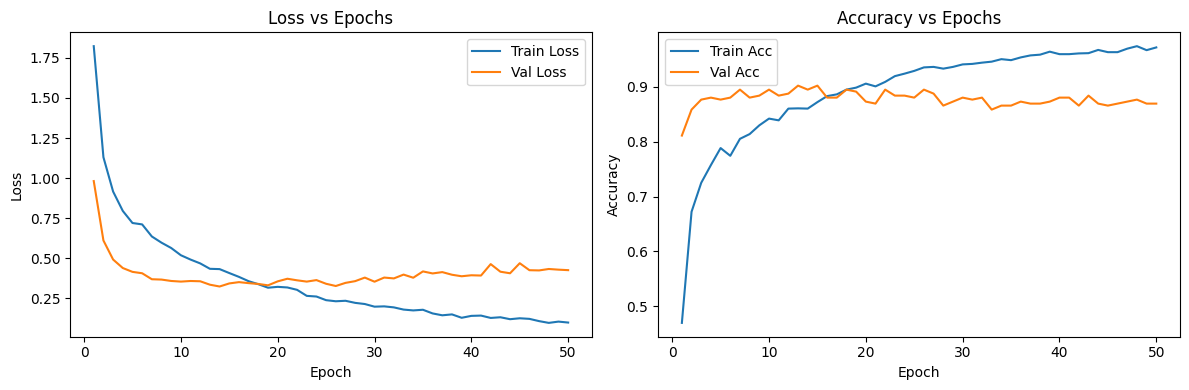

In [14]:
import torchvision.models as models
import torch.nn as nn

# 1. Load pretrained MobileNetV2
mobilenet_v2_case2 = models.mobilenet_v2(pretrained=True)

# 2. Freeze all layers initially
for param in mobilenet_v2_case2.parameters():
    param.requires_grad = False

# 3. Unfreeze last two convolutional layers
# MobileNetV2 uses features[18] and features[17] as last conv blocks
for i in [-1, -2]:  # last two blocks
    for param in mobilenet_v2_case2.features[i].parameters():
        param.requires_grad = True

# 4. Replace the classifier (FC layer)
mobilenet_v2_case2.classifier[1] = nn.Linear(mobilenet_v2_case2.last_channel, 11)

# 5. Ensure classifier is trainable
for param in mobilenet_v2_case2.classifier.parameters():
    param.requires_grad = True

# 6. Move to device
mobilenet_v2_case2 = mobilenet_v2_case2.to(device)
print("✅ MobileNetV2 ready for fine-tuning (last 2 conv + FC)")

# 7. Loss and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, mobilenet_v2_case2.parameters()), lr=1e-4)

# 8. Train for 50 epochs
best_val_acc_case2 = train_model(mobilenet_v2_case2, train_loader, val_loader, optimizer, criterion, num_epochs=50)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model_on_test(model, test_loader, class_names, title='Model'):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            preds = outputs.argmax(dim=1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Calculate overall test accuracy
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy ({title}): {test_acc:.4f}")

    # Create and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()

    # Print detailed classification report (precision, recall, F1-score)
    print("Classification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    ))

    # Return the test accuracy for further use
    return test_acc

✅ Test Accuracy (MobileNetV2 case 1 epoch 50): 0.7491


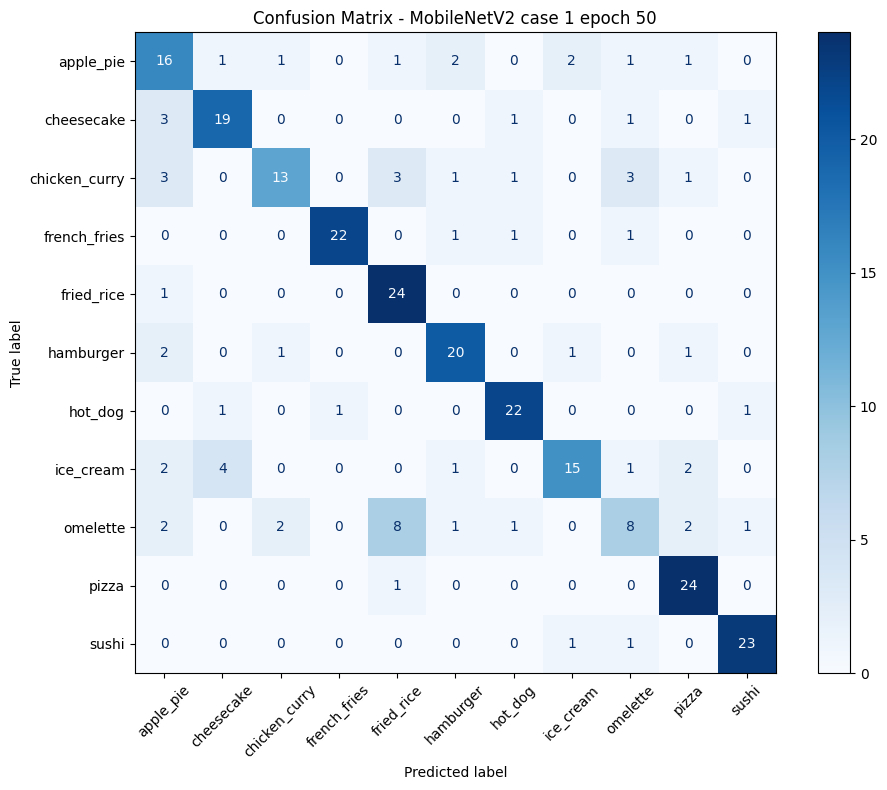

Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.5517    0.6400    0.5926        25
   cheesecake     0.7600    0.7600    0.7600        25
chicken_curry     0.7647    0.5200    0.6190        25
 french_fries     0.9565    0.8800    0.9167        25
   fried_rice     0.6486    0.9600    0.7742        25
    hamburger     0.7692    0.8000    0.7843        25
      hot_dog     0.8462    0.8800    0.8627        25
    ice_cream     0.7895    0.6000    0.6818        25
     omelette     0.5000    0.3200    0.3902        25
        pizza     0.7742    0.9600    0.8571        25
        sushi     0.8846    0.9200    0.9020        25

     accuracy                         0.7491       275
    macro avg     0.7496    0.7491    0.7401       275
 weighted avg     0.7496    0.7491    0.7401       275



In [16]:
acc_case1 = evaluate_model_on_test(mobilenet_v2, test_loader, class_names, title='MobileNetV2 case 1 epoch 50')

✅ Test Accuracy (MobileNetV2 case 2 epoch 50): 0.7927


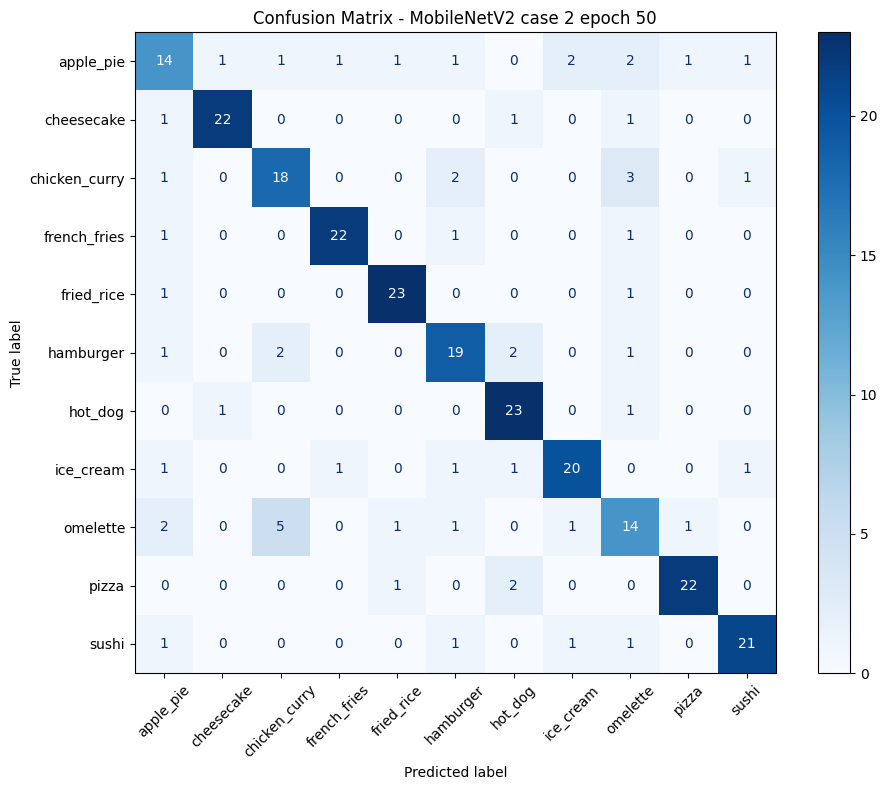

Classification Report:
               precision    recall  f1-score   support

    apple_pie     0.6087    0.5600    0.5833        25
   cheesecake     0.9167    0.8800    0.8980        25
chicken_curry     0.6923    0.7200    0.7059        25
 french_fries     0.9167    0.8800    0.8980        25
   fried_rice     0.8846    0.9200    0.9020        25
    hamburger     0.7308    0.7600    0.7451        25
      hot_dog     0.7931    0.9200    0.8519        25
    ice_cream     0.8333    0.8000    0.8163        25
     omelette     0.5600    0.5600    0.5600        25
        pizza     0.9167    0.8800    0.8980        25
        sushi     0.8750    0.8400    0.8571        25

     accuracy                         0.7927       275
    macro avg     0.7934    0.7927    0.7923       275
 weighted avg     0.7934    0.7927    0.7923       275



In [17]:
acc_case2 = evaluate_model_on_test(mobilenet_v2_case2, test_loader, class_names, title='MobileNetV2 case 2 epoch 50')